In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#range(2005, 2018)
#OneHotEncoder (sexe)
#StandardScaler+SelectKBest
#Anti-OOM
#usagers_sample

In [2]:
# Anti-OOM
import gc, os

pd.options.mode.copy_on_write = True  # pandas 2.x : limite les copies
os.environ["PYTHONHASHSEED"] = "42"

def downcast_numeric(df):
    for c in df.select_dtypes(include=["int64","int32"]).columns:
        df[c] = pd.to_numeric(df[c], downcast="integer")
    for c in df.select_dtypes(include=["float64","float32"]).columns:
        df[c] = pd.to_numeric(df[c], downcast="float")
    return df

def as_category(df, cols):
    for c in cols:
        df[c] = df[c].astype("category")
    return df

def free(*objs):
    for o in objs: del o
    gc.collect()

## Caractéristiques

##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *importation fichier*  -- </font>

In [3]:
##On importe les données et on concatène en un seul DF
caracteristiques_2005_2018 = []
dtypes_caracs = {"dep":"category","com":"category","lum":"int8","agg":"int8","int":"int8","atm":"int8","col":"int8","mois":"int8","jour":"int8","an":"int16"}

for annee in range(2005, 2019):
    chemin = f'C:/Users/enora/Documents/01_Data_scientest/Projet_accident/Data_gouv_2005_2019/caracteristiques_{annee}.csv'
    chemin = f'data/caracteristiques_{annee}.csv' ## chemin Philippe

    sep = '\t' if annee == 2009 else ','
    df = pd.read_csv(chemin, sep=sep, encoding='latin1',  dtype={'dep': str, 'com' : str, 'hrmn' : str})

    df['annee'] = annee
    caracteristiques_2005_2018.append(df)

caracs = pd.concat(caracteristiques_2005_2018, ignore_index=True)
caracs.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,annee
0,200500000001,5,1,12,1900,3,2,1,1.0,3.0,011,CD41B,M,5051500.0,294400.0,590,2005
1,200500000002,5,1,21,1600,1,2,1,1.0,1.0,051,rue de Lille,M,5053700.0,280200.0,590,2005
2,200500000003,5,1,21,1845,3,1,1,2.0,1.0,051,NaN,M,5054600.0,280000.0,590,2005
3,200500000004,5,1,4,1615,1,1,1,1.0,5.0,082,NaN,M,5098700.0,240800.0,590,2005
4,200500000005,5,1,10,1945,3,1,1,3.0,6.0,478,NaN,M,5096400.0,247500.0,590,2005


##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *Première analyse*  -- </font>

In [4]:
caracs.info()

##ajouter describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958469 entries, 0 to 958468
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Num_Acc  958469 non-null  int64  
 1   an       958469 non-null  int64  
 2   mois     958469 non-null  int64  
 3   jour     958469 non-null  int64  
 4   hrmn     958469 non-null  object 
 5   lum      958469 non-null  int64  
 6   agg      958469 non-null  int64  
 7   int      958469 non-null  int64  
 8   atm      958396 non-null  float64
 9   col      958450 non-null  float64
 10  com      958467 non-null  object 
 11  adr      816550 non-null  object 
 12  gps      480052 non-null  object 
 13  lat      471401 non-null  float64
 14  long     471397 non-null  object 
 15  dep      958469 non-null  object 
 16  annee    958469 non-null  int64  
dtypes: float64(3), int64(8), object(6)
memory usage: 124.3+ MB


In [5]:
#On regarde les doublons
doublons = caracs['Num_Acc'].duplicated().sum()
print("Il y a", doublons, "doublons dans Num_Acc \n")

#On regarde les valeurs nulles
print("\nvaleurs nulles :\n")
display(caracs.isna().sum())

##On analyse gps
caracs['gps'].value_counts()

Il y a 0 doublons dans Num_Acc 


valeurs nulles :



Num_Acc         0
an              0
mois            0
jour            0
hrmn            0
lum             0
agg             0
int             0
atm            73
col            19
com             2
adr        141919
gps        478417
lat        487068
long       487072
dep             0
annee           0
dtype: int64

gps
M    462639
A      7850
R      5316
G      3387
Y       842
0         9
S         4
C         2
T         2
P         1
Name: count, dtype: int64

Remarques : adr -> disponible pour les accidents survenus en agglomération. L'adresse precise n'est peut-être pas très importante. On a déjà la colonne agg qui dit en agglo et hors agglo.

lattitude, longitude : trop de données manquantes et pas utile, on supprime

com : à voir si la commune est signifiante ou pas

atm : conditions atmosphériques importantes

col : type de collision -> On supprime Nan

gps : trop de valeurs manquantes et difficile à interpréter. On supprime et on se concentre sur France métropolitaine avec département

On supprime adr, lat et long et gps, on supprime Nan pour le reste

In [6]:
caracs.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,annee
0,200500000001,5,1,12,1900,3,2,1,1.0,3.0,011,CD41B,M,5051500.0,294400.0,590,2005
1,200500000002,5,1,21,1600,1,2,1,1.0,1.0,051,rue de Lille,M,5053700.0,280200.0,590,2005
2,200500000003,5,1,21,1845,3,1,1,2.0,1.0,051,NaN,M,5054600.0,280000.0,590,2005
3,200500000004,5,1,4,1615,1,1,1,1.0,5.0,082,NaN,M,5098700.0,240800.0,590,2005
4,200500000005,5,1,10,1945,3,1,1,3.0,6.0,478,NaN,M,5096400.0,247500.0,590,2005


In [7]:
##On supprime les colonnes inutiles
caracs = caracs.drop(['adr', 'gps', 'lat', 'long'], axis = 1)

In [8]:
##On supprime le reste des valeurs nulles sur atm, col et com
caracs.dropna(inplace=True)

In [9]:
caracs.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,dep,annee
0,200500000001,5,1,12,1900,3,2,1,1.0,3.0,011,590,2005
1,200500000002,5,1,21,1600,1,2,1,1.0,1.0,051,590,2005
2,200500000003,5,1,21,1845,3,1,1,2.0,1.0,051,590,2005
3,200500000004,5,1,4,1615,1,1,1,1.0,5.0,082,590,2005
4,200500000005,5,1,10,1945,3,1,1,3.0,6.0,478,590,2005


In [10]:
## On vérifie s'il reste des Nan
print("\nvaleurs nulles :\n")
display(caracs.isna().sum())


valeurs nulles :



Num_Acc    0
an         0
mois       0
jour       0
hrmn       0
lum        0
agg        0
int        0
atm        0
col        0
com        0
dep        0
annee      0
dtype: int64

In [11]:
##On travaille sur dep pour garder France métropolitaine et Corse
caracs['dep'].value_counts()

sorted(caracs['dep'].unique())

['010',
 '020',
 '030',
 '040',
 '050',
 '060',
 '070',
 '080',
 '090',
 '10',
 '100',
 '110',
 '120',
 '130',
 '140',
 '150',
 '160',
 '170',
 '180',
 '190',
 '20',
 '201',
 '202',
 '210',
 '220',
 '230',
 '240',
 '250',
 '260',
 '270',
 '280',
 '290',
 '30',
 '300',
 '310',
 '320',
 '330',
 '340',
 '350',
 '360',
 '370',
 '380',
 '390',
 '40',
 '400',
 '410',
 '420',
 '430',
 '440',
 '450',
 '460',
 '470',
 '480',
 '490',
 '50',
 '500',
 '510',
 '520',
 '530',
 '540',
 '550',
 '560',
 '570',
 '580',
 '590',
 '60',
 '600',
 '610',
 '620',
 '630',
 '640',
 '650',
 '660',
 '670',
 '680',
 '690',
 '70',
 '700',
 '710',
 '720',
 '730',
 '740',
 '750',
 '760',
 '770',
 '780',
 '790',
 '80',
 '800',
 '810',
 '820',
 '830',
 '840',
 '850',
 '860',
 '870',
 '880',
 '890',
 '90',
 '900',
 '910',
 '920',
 '930',
 '940',
 '950',
 '971',
 '972',
 '973',
 '974',
 '976']

Codes des départements hors métropole (on inclus pas la corse): 971 : Guadeloupe 972 : Martinique 973 : Guyane 974 : La Réunion 976 : Mayotte 975 : Saint-Pierre-et-Miquelon 977 : Saint-Barthélemy 978 : Saint-Martin 984 : Terres australes et antarctiques françaises 986 : Wallis-et-Futuna 987 : Polynésie française 988 : Nouvelle-Calédonie

In [12]:
##On supprime les lignes qui contiennent les département hors FM
Dep_suppr = ['971', '972', '973', '974', '976', '975', '977', '978', '984','986', '987', '988']



caracs = caracs[~caracs['dep'].isin(Dep_suppr)]

## On réinitialise l'index
caracs.reset_index(drop=True, inplace=True)

In [13]:
## On vérifie
caracs['dep'].value_counts()
sorted(caracs['dep'].unique())

['010',
 '020',
 '030',
 '040',
 '050',
 '060',
 '070',
 '080',
 '090',
 '10',
 '100',
 '110',
 '120',
 '130',
 '140',
 '150',
 '160',
 '170',
 '180',
 '190',
 '20',
 '201',
 '202',
 '210',
 '220',
 '230',
 '240',
 '250',
 '260',
 '270',
 '280',
 '290',
 '30',
 '300',
 '310',
 '320',
 '330',
 '340',
 '350',
 '360',
 '370',
 '380',
 '390',
 '40',
 '400',
 '410',
 '420',
 '430',
 '440',
 '450',
 '460',
 '470',
 '480',
 '490',
 '50',
 '500',
 '510',
 '520',
 '530',
 '540',
 '550',
 '560',
 '570',
 '580',
 '590',
 '60',
 '600',
 '610',
 '620',
 '630',
 '640',
 '650',
 '660',
 '670',
 '680',
 '690',
 '70',
 '700',
 '710',
 '720',
 '730',
 '740',
 '750',
 '760',
 '770',
 '780',
 '790',
 '80',
 '800',
 '810',
 '820',
 '830',
 '840',
 '850',
 '860',
 '870',
 '880',
 '890',
 '90',
 '900',
 '910',
 '920',
 '930',
 '940',
 '950']

In [14]:
caracs.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,dep,annee
0,200500000001,5,1,12,1900,3,2,1,1.0,3.0,011,590,2005
1,200500000002,5,1,21,1600,1,2,1,1.0,1.0,051,590,2005
2,200500000003,5,1,21,1845,3,1,1,2.0,1.0,051,590,2005
3,200500000004,5,1,4,1615,1,1,1,1.0,5.0,082,590,2005
4,200500000005,5,1,10,1945,3,1,1,3.0,6.0,478,590,2005


In [15]:
#Création d'une colonne date
caracs['date'] = pd.to_datetime(
    caracs['jour'].astype(str).str.zfill(2) + '-' +
    caracs['mois'].astype(str).str.zfill(2) + '-' +
    caracs['annee'].astype(str),
        format='%d-%m-%Y')

##Création d'une classe moment
# Nettoyage et conversion de l'heure
caracs["hrmn"] = caracs["hrmn"].astype(str).str.replace(":", "", regex=False)
caracs["hrmn"] = caracs["hrmn"].astype(float)
caracs["heure"] = caracs["hrmn"] // 100  # On garde l'heure entière

# Création de la classe du moment de la journée
caracs["moment"] = np.where(caracs["heure"] < 6, "4",
                   np.where(caracs["heure"] < 12, "1",
                   np.where(caracs["heure"] < 18, "2", "3")))

caracs.head()

# atm - Conditions atmosphériques :
# Normal = 1
#    1 – Normale
#    2 – Pluie légère
#    8 – Temps couvert
# Défavorable = 0
#    3 – Pluie forte
#    4 – Neige - grêle
#    5 – Brouillard - fumée
#    6 – Vent fort - tempête
#    7 – Temps éblouissant
# Inconnu = -1
#   -1 – Non renseigné
#    9 - Autre

caracs["atm"] = np.where(caracs["atm"].isin([1, 2, 8]), "1",
                   np.where(caracs["atm"].isin([3, 4, 5, 6, 7]), "0", "-1"))

##Un tableau normal et un tableau avec les jours fériés

In [16]:
caracs.atm.unique()

array(['1', '0', '-1'], dtype=object)

##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *Analyse approfondie*  -- </font>

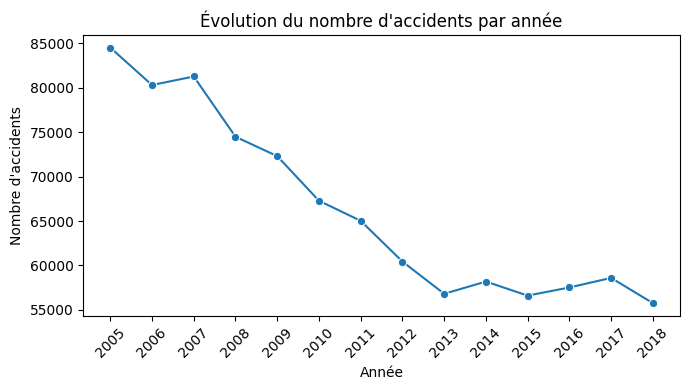

In [17]:
##Nombre d'accident par années

# Compter les accidents par année
accidents_par_annee = caracs['annee'].value_counts().sort_index()

# Liste complète des années (même si certaines années ont 0 accidents)
annees = list(range(2005, 2019))

# S'assurer que toutes les années sont présentes, même avec 0
accidents_par_annee = accidents_par_annee.reindex(annees, fill_value=0)

# Tracer la courbe
plt.figure(figsize=(7, 4))
sns.lineplot(x=accidents_par_annee.index, y=accidents_par_annee.values, marker='o')
plt.title("Évolution du nombre d'accidents par année")
plt.xlabel("Année")
plt.ylabel("Nombre d'accidents")
plt.xticks(annees, rotation=45)
plt.tight_layout()
plt.show()

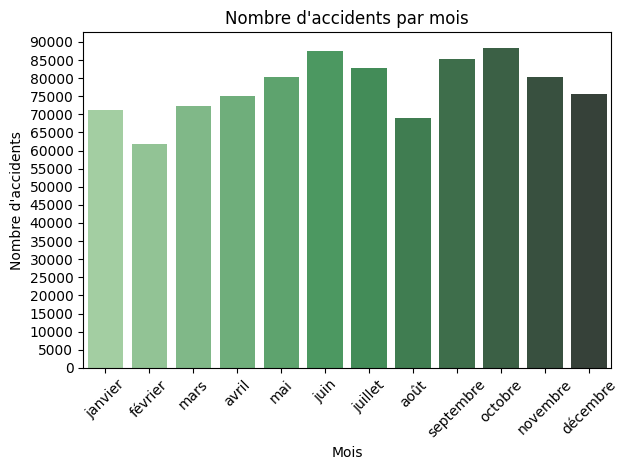

In [18]:
##Nombre d'accidents par mois

# Noms des mois en français
noms_mois = ['janvier', 'février', 'mars', 'avril', 'mai', 'juin',
             'juillet', 'août', 'septembre', 'octobre', 'novembre', 'décembre']

# Compter les accidents par mois
accidents_par_mois = caracs['mois'].value_counts().sort_index()

# Tracé avec palette et suppression du warning via hue
sns.barplot(x=noms_mois, y=accidents_par_mois.values, hue=noms_mois, palette="Greens_d", legend=False)

plt.title("Nombre d'accidents par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'accidents")

# Ajouter plus de ticks sur l'axe Y
max_y = accidents_par_mois.max()
plt.yticks(range(0, max_y + 5000, 5000))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

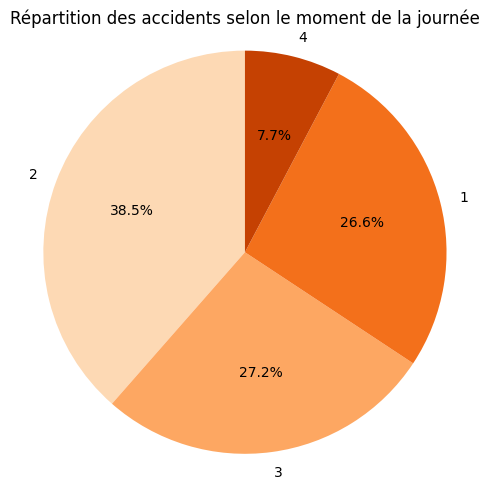

In [19]:
# Comptage réel à partir de caracs
counts = caracs['moment'].value_counts()
moments = counts.index

# Camembert
plt.figure(figsize=(5, 5))
plt.pie(
    counts.values,
    labels=moments,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Oranges", len(moments))
)
plt.title("Répartition des accidents selon le moment de la journée")
plt.axis('equal')
plt.tight_layout()
plt.show()

##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *heatmap*  -- </font>

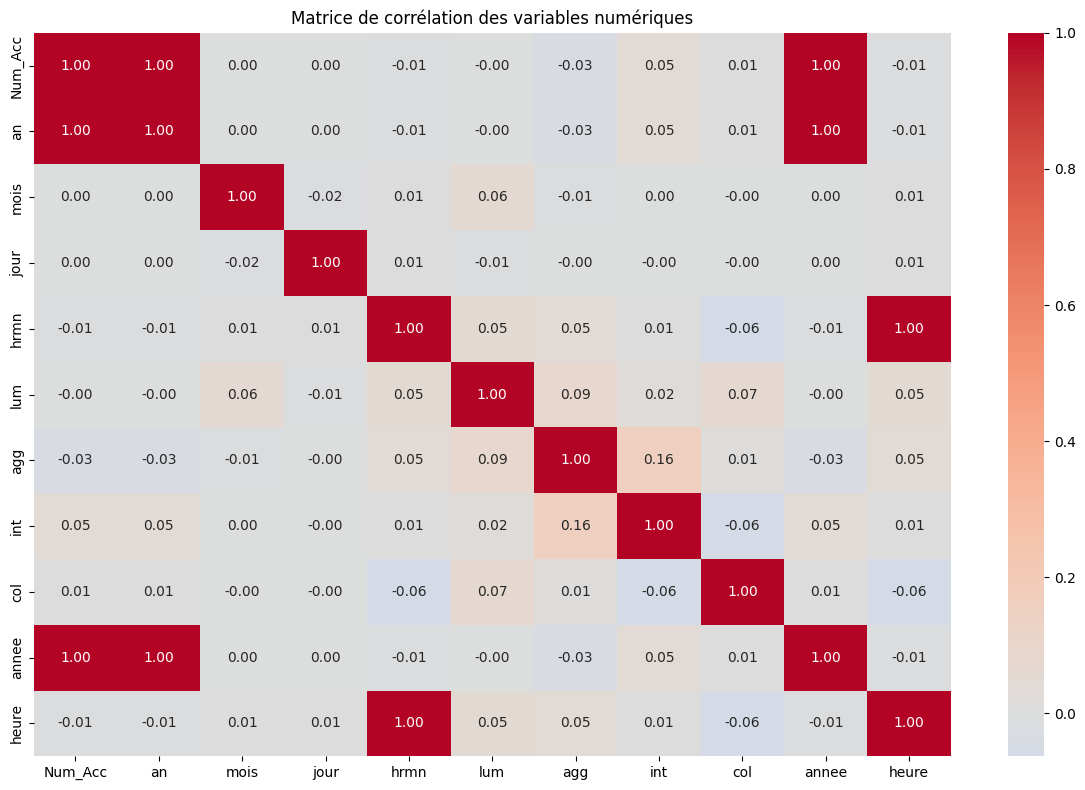

In [20]:
##Plutôt à faire quand DF lié complètement

# Sélection des colonnes numériques
colonnes_numeriques = caracs.select_dtypes(include=['int64', 'float64'])

# Calcul des corrélations
correlation_matrix = colonnes_numeriques.corr()

# Affichage de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title("Matrice de corrélation des variables numériques")
plt.tight_layout()
plt.show()

<font color="blue">Suppression colonnes inutiles</font>


In [21]:
caracs = caracs.drop(["an", "mois", "jour", "hrmn", "heure", "annee"], axis=1)

## Usagers

##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *Importation données* -- </font>

In [22]:
usagers_2005_2018 = []

for annee in range(2005, 2019):
    chemin = f'C:/Users/enora/Documents/01_Data_scientest/Projet_accident/Data_gouv_2005_2019/usagers_{annee}.csv'
    chemin = f'data/usagers_{annee}.csv' ## chemin Philippe

    df = pd.read_csv(chemin, sep=',', encoding='latin1')

    df['annee'] = annee
    usagers_2005_2018.append(df)

usagers = pd.concat(usagers_2005_2018, ignore_index=True)
usagers.head(10)

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh,annee
0,200500000001,1.0,1,4,1,1.0,11.0,0.0,0.0,0.0,1976.0,A01,2005
1,200500000001,1.0,1,3,2,3.0,11.0,0.0,0.0,0.0,1968.0,B02,2005
2,200500000001,2.0,2,1,1,0.0,11.0,0.0,0.0,0.0,1964.0,B02,2005
3,200500000001,4.0,2,1,1,0.0,31.0,0.0,0.0,0.0,2004.0,B02,2005
4,200500000001,5.0,2,1,1,0.0,11.0,0.0,0.0,0.0,1998.0,B02,2005
5,200500000001,3.0,2,1,2,0.0,11.0,0.0,0.0,0.0,1991.0,B02,2005
6,200500000002,1.0,1,1,1,5.0,11.0,0.0,0.0,0.0,1955.0,A01,2005
7,200500000002,1.0,1,3,1,5.0,21.0,0.0,0.0,0.0,1979.0,B02,2005
8,200500000003,1.0,1,1,1,1.0,21.0,0.0,0.0,0.0,1983.0,A01,2005
9,200500000003,1.0,1,3,1,1.0,21.0,0.0,0.0,0.0,1956.0,B02,2005


##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *première analyse*  -- </font>

In [23]:
# infos générales
display(usagers.info())

display(usagers.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142195 entries, 0 to 2142194
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Num_Acc  int64  
 1   place    float64
 2   catu     int64  
 3   grav     int64  
 4   sexe     int64  
 5   trajet   float64
 6   secu     float64
 7   locp     float64
 8   actp     float64
 9   etatp    float64
 10  an_nais  float64
 11  num_veh  object 
 12  annee    int64  
dtypes: float64(7), int64(5), object(1)
memory usage: 212.5+ MB


None

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,annee
count,2.142195e+06,2.019067e+06,2.142195e+06,2.142195e+06,2.142195e+06,2.141701e+06,2.085658e+06,2.085834e+06,2.085733e+06,2.085777e+06,2.139777e+06,2.142195e+06
mean,2.010923e+11,1.302452e+00,1.342253e+00,2.512662e+00,1.328111e+00,3.125395e+00,1.796288e+01,2.307082e-01,2.834946e-01,1.053665e-01,1.973446e+03,2.010923e+03
std,4.081452e+08,9.630573e-01,6.335472e-01,1.334458e+00,4.695255e-01,2.677839e+00,1.929059e+01,8.830024e-01,1.063983e+00,3.849168e-01,1.852290e+01,4.081503e+00
min,2.005000e+11,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.896000e+03,2.005000e+03
25%,2.007001e+11,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.961000e+03,2.007000e+03
50%,2.011000e+11,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,4.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,2.011000e+03
75%,2.014001e+11,1.000000e+00,2.000000e+00,4.000000e+00,2.000000e+00,5.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.987000e+03,2.014000e+03
max,2.018001e+11,9.000000e+00,4.000000e+00,4.000000e+00,2.000000e+00,9.000000e+00,9.300000e+01,8.000000e+00,9.000000e+00,3.000000e+00,2.018000e+03,2.018000e+03


In [24]:
#On regarde les doublons
doublons = usagers['Num_Acc'].duplicated().sum()
print("Il y a", doublons, "doublons dans Num_Acc \n")

#On regarde les valeurs nulles
print("\nvaleurs nulles :\n")
display(usagers.isna().sum())

Il y a 1183726 doublons dans Num_Acc 


valeurs nulles :



Num_Acc         0
place      123128
catu            0
grav            0
sexe            0
trajet        494
secu        56537
locp        56361
actp        56462
etatp       56418
an_nais      2418
num_veh         0
annee           0
dtype: int64

Commentaire :

Pour les doublons :
- Ici les Num_Acc sont répétés pour chaque usagers.
- Les doublons dans usagers sont expliqués par le type de colision, quand plusieurs véhicules sont impliqués ou s'il y avait plusieurs personne dans l'un des véhicules.

##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *Sécurité*  -- </font>

Pour 2005 à 2018 sur 2 caractères :
le premier concerne l’existence d’un Équipement de sécurité
1 – Ceinture
2 – Casque
3 – Dispositif enfants
4 – Equipement réfléchissant
9 – Autre
le second concerne l’utilisation de l’Équipement de sécurité
1 – Oui
2 – Non
3 – Non déterminable

In [25]:
usagers.secu.value_counts(dropna=False)

secu
11.0    1197467
21.0     389504
13.0     166913
93.0     105121
0.0       68374
NaN       56537
23.0      40865
12.0      36315
22.0      22374
31.0      14976
3.0        7707
92.0       7693
91.0       7653
10.0       5631
1.0        3568
2.0        2669
41.0       2532
43.0       2004
42.0       1856
33.0        837
32.0        761
20.0        754
90.0         73
30.0          9
40.0          2
Name: count, dtype: int64

<font color="blue">__PAF__</color>
- quand l'information manque ou NA("x0" => -1)

In [26]:
#Convertir en int64 pour garder les Nan et enlever le 0 inutile
usagers['secu'] = pd.to_numeric(usagers['secu'], errors='coerce').astype('Int64')

#Fonction pour extraire info
#Si équipement utilisé, on l'indique. Si pas utilisé on met 0, si non déterminable, on met 3.
def decode_secu(val):
    if pd.isna(val):
        return -1
    val = int(val)
    equipement = val // 10
    usage = val % 10
    if usage == 1:
        return equipement
    elif usage == 2:
        return 0
    elif usage == 3:
        return -1
    else:
        return -1  # cas imprévu

# Application
usagers['secu'] = usagers['secu'].apply(decode_secu).astype('Int64')
usagers.head()

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh,annee
0,200500000001,1.0,1,4,1,1.0,1,0.0,0.0,0.0,1976.0,A01,2005
1,200500000001,1.0,1,3,2,3.0,1,0.0,0.0,0.0,1968.0,B02,2005
2,200500000001,2.0,2,1,1,0.0,1,0.0,0.0,0.0,1964.0,B02,2005
3,200500000001,4.0,2,1,1,0.0,3,0.0,0.0,0.0,2004.0,B02,2005
4,200500000001,5.0,2,1,1,0.0,1,0.0,0.0,0.0,1998.0,B02,2005


In [27]:
usagers.secu.value_counts(dropna=False)

secu
1     1197467
-1     454827
2      389504
0       75236
3       14976
9        7653
4        2532
Name: count, dtype: Int64

print(usagers.secu.value_counts(dropna=False))
def decode_secu2(val):
    if pd.isna(val):
        return np.nan
    val = int(val)
    equipement = val // 10
    usage = val % 10
    if usage == 1:
        return equipement
    elif usage == 2:
        return 0
    elif usage == 3:
        return -1
    else:
        return 4  # cas imprévu

### Application
usagers['secu'].apply(decode_secu2).astype('Int64').value_counts(dropna=False)


In [28]:
usagers.secu.unique()

<IntegerArray>
[1, 3, 2, -1, 0, 9, 4]
Length: 7, dtype: Int64

##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *Analyse appronfondi et preprocessing données*  -- </font>

In [29]:
## On supprime colonne num_veh car on l'aura déjà travaillé dans le df véhicules
usagers = usagers.drop(columns=['num_veh'])
usagers.head(10)

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,annee
0,200500000001,1.0,1,4,1,1.0,1,0.0,0.0,0.0,1976.0,2005
1,200500000001,1.0,1,3,2,3.0,1,0.0,0.0,0.0,1968.0,2005
2,200500000001,2.0,2,1,1,0.0,1,0.0,0.0,0.0,1964.0,2005
3,200500000001,4.0,2,1,1,0.0,3,0.0,0.0,0.0,2004.0,2005
4,200500000001,5.0,2,1,1,0.0,1,0.0,0.0,0.0,1998.0,2005
5,200500000001,3.0,2,1,2,0.0,1,0.0,0.0,0.0,1991.0,2005
6,200500000002,1.0,1,1,1,5.0,1,0.0,0.0,0.0,1955.0,2005
7,200500000002,1.0,1,3,1,5.0,2,0.0,0.0,0.0,1979.0,2005
8,200500000003,1.0,1,1,1,1.0,2,0.0,0.0,0.0,1983.0,2005
9,200500000003,1.0,1,3,1,1.0,2,0.0,0.0,0.0,1956.0,2005


On regroupe pour n'avoir qu'une Num_Acc

###### <font color="purple"> &nbsp;&nbsp;&nbsp;-- *Variable Sexe*  -- </font>

In [30]:
##On divise la colonne sexe en 2
'''X = usagers[['sexe']]

enc = OneHotEncoder(handle_unknown='ignore')
X_enc = enc.fit_transform(X).toarray()

col_names = enc.get_feature_names_out(['sexe'])
sexe_encoded = pd.DataFrame(X_enc, columns=col_names, index=usagers.index).astype(int)

sexe_encoded = sexe_encoded.rename(columns={
    'sexe_1': 'Homme',
    'sexe_2': 'Femme'
})

usagers = pd.concat([usagers, sexe_encoded], axis=1)
'''

usagers["Homme"] = (usagers["sexe"] == 1).astype("int8")
usagers["Femme"] = (usagers["sexe"] == 2).astype("int8")

usagers.head()

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,annee,Homme,Femme
0,200500000001,1.0,1,4,1,1.0,1,0.0,0.0,0.0,1976.0,2005,1,0
1,200500000001,1.0,1,3,2,3.0,1,0.0,0.0,0.0,1968.0,2005,0,1
2,200500000001,2.0,2,1,1,0.0,1,0.0,0.0,0.0,1964.0,2005,1,0
3,200500000001,4.0,2,1,1,0.0,3,0.0,0.0,0.0,2004.0,2005,1,0
4,200500000001,5.0,2,1,1,0.0,1,0.0,0.0,0.0,1998.0,2005,1,0


In [31]:
# Agrégation par accident
sexe_acc = usagers.groupby('Num_Acc', as_index=False)[['Homme','Femme']].sum()

sexe_acc.head()

,Num_Acc,Homme,Femme
0,200500000001,4,2
1,200500000002,2,0
2,200500000003,2,0
3,200500000004,2,2
4,200500000005,2,0


In [32]:
usagers = usagers.drop(['sexe'], axis = 1)
usagers.head()

,Num_Acc,place,catu,grav,trajet,secu,locp,actp,etatp,an_nais,annee,Homme,Femme
0,200500000001,1.0,1,4,1.0,1,0.0,0.0,0.0,1976.0,2005,1,0
1,200500000001,1.0,1,3,3.0,1,0.0,0.0,0.0,1968.0,2005,0,1
2,200500000001,2.0,2,1,0.0,1,0.0,0.0,0.0,1964.0,2005,1,0
3,200500000001,4.0,2,1,0.0,3,0.0,0.0,0.0,2004.0,2005,1,0
4,200500000001,5.0,2,1,0.0,1,0.0,0.0,0.0,1998.0,2005,1,0


<font color="red">Commentaire :
Ce que je n'ai pas fait, regarder si c'est plus interessant d'avoir le nombre total d'hommes et de femmes plutôt que juste 1 si au moins 1 est présent. </font>

<font color="blue">__PAF__</color>
- création d'une (seule) variable avec 3 modalités (0 : aucun, 1: 1, 2: plusieurs) ?

In [33]:
# Création d'une variable avec 3 modalités (0 : aucun, 1: 1, 2: plusieurs)
for sex in ["Homme", "Femme"]:
    sexe_acc[f"pres_{sex}"] = np.where(sexe_acc[sex] == 0, 0, np.where(sexe_acc[sex] == 1, 1, 2) )
sexe_acc


,Num_Acc,Homme,Femme,pres_Homme,pres_Femme
0,200500000001,4,2,2,2
1,200500000002,2,0,2,0
2,200500000003,2,0,2,0
3,200500000004,2,2,2,2
4,200500000005,2,0,2,0
...,...,...,...,...,...
958464,201800057779,2,0,2,0
958465,201800057780,1,0,1,0
958466,201800057781,2,0,2,0
958467,201800057782,1,1,1,1


In [34]:
# Suppression des colonnes Homme et Femme
sexe_acc = sexe_acc.drop(["Homme", "Femme"], axis=1)

###### <font color="purple"> &nbsp;&nbsp;&nbsp;-- *Catu et présence piéton*  -- </font>

In [35]:
usagers.locp.value_counts(dropna=False, normalize=True)

locp
0.0    0.897728
NaN    0.026310
4.0    0.020377
2.0    0.019621
3.0    0.016102
1.0    0.012037
5.0    0.005202
6.0    0.001678
8.0    0.000850
7.0    0.000096
Name: proportion, dtype: float64

In [36]:
## On test la corrélation entre la présence d'un piéton et la variable cible
usagers['pieton'] = (usagers['catu'] == 3).astype(int)  # catu=3 → piéton
acc_pieton = usagers.groupby('Num_Acc', as_index=False)['pieton'].max()

for col in ['locp','actp','etatp']:
    print(col, usagers[col].isna().mean())

locp 0.026309929768298403
actp 0.026357077670333465
etatp 0.026336537990238985


In [37]:
#Nombre de piétons max par accident => 1
acc_pieton.iloc[:,1].unique()

array([0, 1])

Commentaire :
- Il n'y que 2,6 % de lignes avec info piéton → logique, car la majorité des accidents n’impliquent pas de piétons.
- locp, actp, etap sont donc des variables spécifiques aux accidents avec piéton.

<font color="blue">__Remarque_PAF:__ </font>:
- Je ne comprends pas ce commentaire : "Il n"y a que 2,6%.." (ça correspond au % de lignes avec l'info manquante)
- Essayer de ne pas utiliser le même nom de variable (ex: "tab") pour des objets différents
- Je ne comprends pas ce commentaire : "La proportion de tués (grav=2) .."

In [38]:
usagers.locp.value_counts()

locp
0.0    1923108
4.0      43652
2.0      42032
3.0      34493
1.0      25786
5.0      11143
6.0       3594
8.0       1821
7.0        205
Name: count, dtype: int64

In [39]:
## On regarde si la présence d'un piéton modifie la gravité
usagers_sample = usagers.sample(n=500_000, random_state=42)
tab = pd.crosstab(usagers_sample['grav'], usagers_sample['pieton'])
chi2, p, _, _ = chi2_contingency(tab)

n = tab.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(tab.shape)-1)))

print(tab)
print(f"Chi²={chi2:.2f}, p-value={p:.4g}")
print(f"Cramér's V pour is_pieton = {cramers_v:.3f}")

pieton       0      1
grav                 
1       203118    808
2        11494   1815
3        88827  15455
4       154732  23751
Chi²=28730.51, p-value=0
Cramér's V pour is_pieton = 0.240


In [40]:
# Nb accidents avec piétons (178118 et non 112 118)
tab.iloc[:,1].sum()

np.int64(41829)

Commentaire :  
- il y a 101 370 blessés légers chez les pietons (grav=4), contre 663 021 sans piéton.
- La proportion de tués (grav=2) est bien plus élevée quand un piéton est impliqué (7677 sur 112 118 = 6,8 %) que sans piéton (49 904 sur 1 964 077 = 2,5 %).

- La statistique χ² est énorme → ça veut dire qu’il y a une forte différence entre les distributions. p-value = 0 -> la différence est significative.

- La présence d’un piéton est très fortement corrélée à la gravité.
- Les accidents avec piéton impliqué ont une proportion beaucoup plus élevée de tués et de blessés hospitalisés que les accidents sans piéton.

Cramer confirme que la variable est hautement significative

In [41]:
## On regarde si la présence d'un piéton modifie la gravité avec une cariable au hasard
# garder uniquement les lignes piétons
pietons = usagers_sample[usagers_sample['catu']==3]

# tableau croisé locp × grav
pd.crosstab(pietons['locp'], pietons['grav'], normalize='index') * 100

grav,1,2,3,4
locp,,,,
0.0,2.975779,4.775087,38.846597,53.402537
1.0,1.769166,9.789385,43.656276,44.785173
2.0,1.134254,3.578057,36.945762,58.341926
3.0,1.330655,2.385137,33.680643,62.603565
4.0,1.848539,2.385212,34.178096,61.588153
5.0,4.487964,3.712770,36.066911,55.732354
6.0,5.491991,16.247140,48.627002,29.633867
7.0,1.886792,9.433962,35.849057,52.830189
8.0,2.850356,2.375297,32.066508,62.707838


Commentaire :
- Les distributions changent selon la localisation :
- Par ex. locp=1 a une proportion de tués plus élevée (≈ 9,6 %) que locp=2  (≈ 3,7 %).
- locp=6 a aussi beaucoup de blessés hospitalisés (≈ 48 %).
A première vue : locp contient de l’information utile : certaines localisations sont associées à des accidents plus graves.

In [42]:
## On fait tout d'un coup

# variables à tester
vars_to_test = ['locp', 'actp', 'etatp']

for var in vars_to_test:
    print(f"\n### Variable : {var}")

    # tableau de contingence (effectifs)
    tab = pd.crosstab(pietons[var], pietons['grav'])

    # test du chi²
    chi2, p, _, _ = chi2_contingency(tab)

    n = tab.sum().sum()
    ## Cramer
    cramers_v = np.sqrt(chi2 / (n * (min(tab.shape)-1)))

    print(tab)
    print(f"Chi² = {chi2:.2f}, p-value = {p:.4g}")
    print(f"Cramér's V pour actp = {cramers_v:.3f}")

    # tableau en % pour lecture plus intuitive
    tab_pct = pd.crosstab(pietons[var], pietons['grav'], normalize='index') * 100
    print("\nRépartition (%) :")
    display(tab_pct.round(2))



### Variable : locp
grav    1    2     3     4
locp                      
0.0   129  207  1684  2315
1.0   105  581  2591  2658
2.0   110  347  3583  5658
3.0   106  190  2683  4987
4.0   186  240  3439  6197
5.0   110   91   884  1366
6.0    48  142   425   259
7.0     1    5    19    28
8.0    12   10   135   264
Chi² = 1613.82, p-value = 0
Cramér's V pour actp = 0.113

Répartition (%) :


grav,1,2,3,4
locp,,,,
0.0,2.98,4.78,38.85,53.40
1.0,1.77,9.79,43.66,44.79
2.0,1.13,3.58,36.95,58.34
3.0,1.33,2.39,33.68,62.60
4.0,1.85,2.39,34.18,61.59
5.0,4.49,3.71,36.07,55.73
6.0,5.49,16.25,48.63,29.63
7.0,1.89,9.43,35.85,52.83
8.0,2.85,2.38,32.07,62.71



### Variable : actp
grav    1     2      3      4
actp                         
0.0   108   148    763   1073
1.0    63   226    997    977
2.0    49   121    471    520
3.0   436  1057  10947  17788
4.0    15    26    283    443
5.0    23    29    910   1450
6.0     8     9     48     27
9.0   106   197   1027   1460
Chi² = 945.35, p-value = 1.207e-186
Cramér's V pour actp = 0.087

Répartition (%) :


grav,1,2,3,4
actp,,,,
0.0,5.16,7.07,36.47,51.29
1.0,2.78,9.99,44.06,43.17
2.0,4.22,10.42,40.57,44.79
3.0,1.44,3.50,36.21,58.85
4.0,1.96,3.39,36.90,57.76
5.0,0.95,1.20,37.73,60.12
6.0,8.70,9.78,52.17,29.35
9.0,3.80,7.06,36.81,52.33



### Variable : etatp
grav     1     2      3      4
etatp                         
0.0     76    82    910   1409
1.0    272  1434  11188  16920
2.0    374   247   2721   4438
3.0     85    50    626    969
Chi² = 655.37, p-value = 2.703e-135
Cramér's V pour actp = 0.072

Répartition (%) :


grav,1,2,3,4
etatp,,,,
0.0,3.07,3.31,36.74,56.88
1.0,0.91,4.81,37.53,56.75
2.0,4.81,3.17,34.97,57.04
3.0,4.91,2.89,36.18,56.01


<font color="blue">__Remarque:__ </font>
- manque la définition de la variable n (qui reprend en fait la valeur n de la cellule précédente

- Au premier abord, les résultats montrent que les trois variables sont significatives pour la gravité.
(Pour etatp : les distributions sont identiques.)
- Lorsqu'on complète avec test de Cramer on réalise que les variable sont statistiquement significative car dataset énorme. Mais en pratique leur pouvoir explicatif est faible.

On va donc uniquement garder la variable 'pieton' qui elle est hautement significative

<font color="blue">__Remarque:__ </font>
- Est-ce que l'on ne perd pas de l'information en supprimant ces 3 variables (qui sont pourtant significatives pour la gravité).
    Ne devrions-nous pas plutôt passer (dans un second temps) une couche de réduction de dimensions (ex: PCA?)?

In [43]:
##On supprime les trois variables
usagers = usagers.drop(['locp', 'actp', 'etatp'], axis = 1)
usagers.head()

,Num_Acc,place,catu,grav,trajet,secu,an_nais,annee,Homme,Femme,pieton
0,200500000001,1.0,1,4,1.0,1,1976.0,2005,1,0,0
1,200500000001,1.0,1,3,3.0,1,1968.0,2005,0,1,0
2,200500000001,2.0,2,1,0.0,1,1964.0,2005,1,0,0
3,200500000001,4.0,2,1,0.0,3,2004.0,2005,1,0,0
4,200500000001,5.0,2,1,0.0,1,1998.0,2005,1,0,0


###### <font color="purple"> &nbsp;&nbsp;&nbsp;-- *Variable place*  -- </font>

In [44]:
## On observe la variable

pourcentage = round(usagers['place'].isna().sum() / len(usagers),
                    2) * 100

print(f"Il y a {pourcentage} % de données manquantes.", end="\n\n")

nombre = usagers['place'].nunique()

print(f'Il y a {nombre} place différentes.', end="\n\n")

print(usagers['place'].value_counts(normalize=True,
                                                 dropna=False).head(10),
      end="\n\n")

# Les places 1 et 2 sont majoritaires.

Il y a 6.0 % de données manquantes.

Il y a 10 place différentes.

place
1.0    0.745081
2.0    0.105462
NaN    0.057477
0.0    0.028366
3.0    0.023727
4.0    0.020356
5.0    0.011702
8.0    0.002799
7.0    0.002190
9.0    0.001904
Name: proportion, dtype: float64



In [45]:
##On analyse la variable place

# tableau de contingence
tab = pd.crosstab(usagers_sample['place'], usagers_sample['grav'])

# test du chi²
chi2, p, _, _ = chi2_contingency(tab)

n = tab.sum().sum()
## Cramer
cramers_v = np.sqrt(chi2 / (n * (min(tab.shape)-1)))

print(tab)
print(f"Chi² = {chi2:.2f}, p-value = {p:.4g}")
print(f"Cramér's V pour place = {cramers_v:.3f}")

# tableau en % pour lecture plus intuitive
tab_pct = pd.crosstab(usagers_sample['place'], usagers_sample['grav'], normalize='index') * 100
print("\nRépartition (%) :")
display(tab_pct.round(2))

grav        1     2      3       4
place                             
0.0       440   560   5314    7944
1.0    176586  9256  69170  117105
2.0     15611  1413  12572   23178
3.0      3961   290   2462    5254
4.0      3372   255   2068    4543
5.0      1917   168   1404    2344
6.0       186     7     78     193
7.0       421    21    194     427
8.0       491    46    313     568
9.0       408    21    210     301
Chi² = 17831.76, p-value = 0
Cramér's V pour place = 0.112

Répartition (%) :


grav,1,2,3,4
place,,,,
0.0,3.09,3.93,37.27,55.72
1.0,47.45,2.49,18.59,31.47
2.0,29.58,2.68,23.82,43.92
3.0,33.10,2.42,20.57,43.90
4.0,32.94,2.49,20.20,44.37
5.0,32.86,2.88,24.07,40.19
6.0,40.09,1.51,16.81,41.59
7.0,39.60,1.98,18.25,40.17
8.0,34.63,3.24,22.07,40.06


__Commentaire pour place__ :

__Analyse générale__
- place = 1.0 (conducteur) : 47.53 % des blessés légers (gravité = 1) sont des conducteurs → énorme surreprésentation par rapport aux autres places.
- place = 2.0 (passager avant droit) : 29.50 % blessés légers → aussi beaucoup touché, mais un peu moins que le conducteur.
- places arrière (3, 4, 5, …) : autour de 32-38 % blessés légers → plus homogènes entre elles.
- place = 0.0 (piéton ?) : 55.79 % de gravité 4 (probablement décès ou blessure grave) → cohérent, car piétons sont plus exposés.
  
__Conclusion__
- Les conducteurs et passagers avant concentrent beaucoup d’accidents légers (gravité 1).
- Les piétons ont un risque beaucoup plus élevé de gravité extrême.
- L’association est forte

__Résumé__ :
- La grande majorité = place 1 (conducteur) → 74 %
- Ensuite place 2 (passager avant) → 10 %
- Les autres places sont très rares (<3 % chacune).
- Cramér’s V = 0.379 → lien modéré à fort avec la gravité → donc la variable est informative.

__Pour simplifier__ :
- Conducteur : place 1
- Passager avant : place 2
- Passager arrière : places 3 à 6
- Autres / indéterminé : places 7, 8, 9, 0

In [46]:
## On réencode la variable place et on test plusieurs méthodes

##On regroupe
def regroupe_place(val):
    if val == 1:
        return "Conducteur"
    elif val == 2:
        return "Avant"
    elif val in [3,4,5,6]:
        return "Arrière"
    else:
        return "Autre"

usagers['place_grp'] = usagers['place'].apply(regroupe_place)

In [47]:
##Version binaire :
usagers_bin = usagers.copy()

#On fait un one hot encoding
usagers_bin = pd.get_dummies(usagers_bin, columns=['place_grp'], prefix='', prefix_sep='', dtype=int)

#On agrègue
place_acc_bin = usagers_bin.groupby('Num_Acc', as_index=False)[['Conducteur','Avant','Arrière','Autre']].max()

place_acc_bin.head()

,Num_Acc,Conducteur,Avant,Arrière,Autre
0,200500000001,1,1,1,0
1,200500000002,1,0,0,0
2,200500000003,1,0,0,0
3,200500000004,1,1,0,0
4,200500000005,1,1,0,0


In [48]:
##Version comptage
usagers_count = usagers.copy()

#On fait un one hot encoding
usagers_count = pd.get_dummies(usagers_count, columns=['place_grp'], prefix='', prefix_sep='', dtype=int)

#On agrègue
place_acc_count = (usagers_count
                   .groupby('Num_Acc', as_index=False)[['Conducteur','Avant','Arrière','Autre']]
                   .sum())

place_acc_count.head()

,Num_Acc,Conducteur,Avant,Arrière,Autre
0,200500000001,2,1,3,0
1,200500000002,2,0,0,0
2,200500000003,2,0,0,0
3,200500000004,3,1,0,0
4,200500000005,1,1,0,0


In [49]:
## On test les variables

# Gravité max par accident
grav_acc = usagers_sample.groupby('Num_Acc', as_index=False)['grav'].max()

# Fusionner
bin_df   = place_acc_bin.merge(grav_acc, on='Num_Acc')
count_df = place_acc_count.merge(grav_acc, on='Num_Acc')

# Fonction Cramér's V
def cramers_v(col, y):
    tab = pd.crosstab(col, y)
    chi2, _, _, _ = chi2_contingency(tab)
    n = tab.values.sum()
    return np.sqrt(chi2 / (n * (min(tab.shape)-1)))


# Comparaison
for col in ['Conducteur','Avant','Arrière','Autre']:
    v_bin = cramers_v(bin_df[col],   bin_df['grav'])
    v_cnt = cramers_v(count_df[col], count_df['grav'])
    print(f"{col:10s}  V(binaire)={v_bin:.3f}   V(comptage)={v_cnt:.3f}")

Conducteur  V(binaire)=0.063   V(comptage)=0.108
Avant       V(binaire)=0.013   V(comptage)=0.012
Arrière     V(binaire)=0.031   V(comptage)=0.022
Autre       V(binaire)=0.052   V(comptage)=0.037


__Commentaire :__
- Seul le "Conducteur" et "Autre" plus interessant en comptage. Les autres variables sont plus interessantes en binaire.
- Comme le nombre de conducteur indique également le nombre de véhicule, qu'on a cette info dans un autre dataset, et que le différence pour "Autre" est minime, on va garder les variables en binaire.

In [50]:
usagers.head()

,Num_Acc,place,catu,grav,trajet,secu,an_nais,annee,Homme,Femme,pieton,place_grp
0,200500000001,1.0,1,4,1.0,1,1976.0,2005,1,0,0,Conducteur
1,200500000001,1.0,1,3,3.0,1,1968.0,2005,0,1,0,Conducteur
2,200500000001,2.0,2,1,0.0,1,1964.0,2005,1,0,0,Avant
3,200500000001,4.0,2,1,0.0,3,2004.0,2005,1,0,0,Arrière
4,200500000001,5.0,2,1,0.0,1,1998.0,2005,1,0,0,Arrière


In [51]:
## On applique la version binaire à usagers

#On fait un one hot encoding
usagers = pd.get_dummies(usagers, columns=['place_grp'], prefix='', prefix_sep='', dtype=int)

#On agrègue
place_acc = usagers.groupby('Num_Acc', as_index=False)[['Conducteur','Avant','Arrière','Autre']].max()

place_acc.head()

,Num_Acc,Conducteur,Avant,Arrière,Autre
0,200500000001,1,1,1,0
1,200500000002,1,0,0,0
2,200500000003,1,0,0,0
3,200500000004,1,1,0,0
4,200500000005,1,1,0,0


###### <font color="purple"> &nbsp;&nbsp;&nbsp;-- *Variable trajet*  -- </font>

In [52]:
## On analyse les catégories de la variable

pourcentage = round(usagers['trajet'].isna().sum() / len(usagers),
                    2) * 100

print(f"Il y a {pourcentage} % de données manquantes.", end="\n\n")

nombre = usagers['trajet'].nunique()

print(f'Il y a {nombre} trajets différentes.', end="\n\n")

print(usagers['trajet'].value_counts(normalize=True,
                                                 dropna=False).head(10),
      end="\n\n")


Il y a 0.0 % de données manquantes.

Il y a 7 trajets différentes.

trajet
5.0    0.371765
0.0    0.283943
1.0    0.130300
4.0    0.097875
9.0    0.069516
3.0    0.025667
2.0    0.020705
NaN    0.000231
Name: proportion, dtype: float64



In [53]:
usagers.head()

,Num_Acc,place,catu,grav,trajet,secu,an_nais,annee,Homme,Femme,pieton,Arrière,Autre,Avant,Conducteur
0,200500000001,1.0,1,4,1.0,1,1976.0,2005,1,0,0,0,0,0,1
1,200500000001,1.0,1,3,3.0,1,1968.0,2005,0,1,0,0,0,0,1
2,200500000001,2.0,2,1,0.0,1,1964.0,2005,1,0,0,0,0,1,0
3,200500000001,4.0,2,1,0.0,3,2004.0,2005,1,0,0,1,0,0,0
4,200500000001,5.0,2,1,0.0,1,1998.0,2005,1,0,0,1,0,0,0


In [54]:
##On analyse variable

# tableau de contingence (effectifs)
tab = pd.crosstab(usagers_sample['trajet'], usagers_sample['grav'])

# test du chi²
chi2, p, _, _ = chi2_contingency(tab)

n = tab.sum().sum()

## Cramer
cramers_v = np.sqrt(chi2 / (n * (min(tab.shape)-1)))

print(tab)
print(f"Chi² = {chi2:.2f}, p-value = {p:.4g}")
print(f"Cramér's V pour place = {cramers_v:.3f}")

# tableau en % pour lecture plus intuitive
tab_pct = pd.crosstab(usagers_sample['trajet'], usagers_sample['grav'], normalize='index') * 100
print("\nRépartition (%) :")
display(tab_pct.round(2))

grav        1     2      3      4
trajet                           
0.0     54844  2998  29277  55248
1.0     24981  1445  13340  25707
2.0      2454   154   2713   4950
3.0      5337   541   3300   3655
4.0     31033   487   4377  12878
5.0     70747  6659  44718  63092
9.0     14493  1022   6529  12883
Chi² = 16302.44, p-value = 0
Cramér's V pour place = 0.104

Répartition (%) :


grav,1,2,3,4
trajet,,,,
0.0,38.52,2.11,20.56,38.81
1.0,38.15,2.21,20.37,39.26
2.0,23.89,1.50,26.41,48.19
3.0,41.59,4.22,25.71,28.48
4.0,63.62,1.00,8.97,26.40
5.0,38.20,3.60,24.14,34.06
9.0,41.50,2.93,18.69,36.89


__Commentaire :__
- Les modalités 9,3 et 2 sont rares, on peut les regrouper en une catégorie.
- On créé ensuite des classes pour les autres modalités : Travail, Pro, Loisirs, Inconnu.

In [55]:
## Questionnement, a quoi correspond la catégorie 0 ?
print(usagers['trajet'].unique())
print(usagers['trajet'].isna().sum())

[ 1.  3.  0.  5.  9.  4.  2. nan]
494


## Test des df bruts

In [56]:
##Je regarde si dans mon dataset original, c'est la même chose et que ça ne vient pas d'un problème d'importation.
usagers_2005_2018 = []

for annee in range(2005, 2019):
    chemin = f'C:/Users/enora/Documents/01_Data_scientest/Projet_accident/Data_gouv_2005_2019/usagers_{annee}.csv'
    chemin = f'data/usagers_{annee}.csv'

    df = pd.read_csv(chemin, sep=',', encoding='latin1')

    df['annee'] = annee
    usagers_2005_2018.append(df)

usagers_bis = pd.concat(usagers_2005_2018, ignore_index=True)
usagers.head(10)

print(usagers_bis['trajet'].unique())
print(usagers_bis['trajet'].isna().sum())

##Il y avait déjà des 0 dans le dataSet original

[ 1.  3.  0.  5.  9.  4.  2. nan]
494


In [57]:
def regroupe_trajet(val):
    if pd.isna(val) or val == 0:
        return "Inconnu"
    elif val == 1:
        return "Travail"          # Domicile – travail
    elif val == 4:
        return "Professionnel"    # Utilisation pro
    elif val == 5:
        return "Loisirs"          # Promenade – loisirs
    elif val in [2, 3, 9]:
        return "Autre"            # Ecole + Courses + Autre regroupés
    else:
        return "Autre"            # Sécurité si valeur imprévue

# Appliquer le regroupement
usagers['trajet_grp'] = usagers['trajet'].apply(regroupe_trajet)

# Vérifier les nouvelles catégories
print(usagers['trajet_grp'].value_counts(normalize=True))

trajet_grp
Loisirs          0.371765
Inconnu          0.284173
Travail          0.130300
Autre            0.115887
Professionnel    0.097875
Name: proportion, dtype: float64


In [58]:
## On vérifie que ce n'est pas lié à des piétons
# Vérifier la proportion d'"Inconnu" par type d'usager
usagers['trajet_grp'] = usagers['trajet'].apply(regroupe_trajet)

tab = pd.crosstab(usagers_bis['catu'], usagers['trajet_grp'], normalize='index', dropna=False) * 100
print(tab.round(1))

trajet_grp  Autre  Inconnu  Loisirs  Professionnel  Travail
catu                                                       
1            11.6     20.2     39.6           12.3     16.4
2             5.2     66.8     24.2            2.3      1.6
3            24.8     23.4     42.2            2.9      6.6
4            19.8     23.4     48.9            1.4      6.5


__Commentaire :__
La catégorie “Inconnu” n’est pas uniquement liée aux piétons.

Conducteurs : 20 %
Piétons : 23 %
Autres usagers : 23 %

<span style="color:red">Donc on a un vrai problème de qualité de saisie qui touche tous les types d’usagers, mais un peu plus marqué pour les piétons et les “autres”.
Du coup, garder “Inconnu” comme modalité à part peut-être pertinent ?
Ou on les remplace par autre chose ? Mode ? Médiane ? </span>

<font color="blue">__Remarque Philippe:__ </font>
- on garde et on ne modifie pas car cette modalité représente un nombre significatif d'entrées (on dénaturerait les données si on la modifie?)

###### <font color="purple"> &nbsp;&nbsp;&nbsp;-- *Variable an_nais*  -- </font>

In [59]:
##On passe la variable en Int64
usagers['an_nais'] = usagers['an_nais'].astype('Int64')

In [60]:
##On analyse variable

# tableau de contingence (effectifs)
tab = pd.crosstab(usagers_sample['an_nais'], usagers_sample['grav'])

# test du chi²
chi2, p, _, _ = chi2_contingency(tab)

n = tab.sum().sum()

## Cramer
cramers_v = np.sqrt(chi2 / (n * (min(tab.shape)-1)))

print(tab)
print(f"Chi² = {chi2:.2f}, p-value = {p:.4g}")
print(f"Cramér's V pour place = {cramers_v:.3f}")

# tableau en % pour lecture plus intuitive
tab_pct = pd.crosstab(usagers_sample['an_nais'], usagers_sample['grav'], normalize='index') * 100
print("\nRépartition (%) :")
display(tab_pct.round(2))

grav       1  2   3    4
an_nais                 
1898.0     4  0   2    5
1899.0     0  0   1    1
1900.0    13  0   6   12
1901.0     5  0   1    1
1903.0     1  0   0    1
...      ... ..  ..  ...
2014.0   106  6  57  184
2015.0    97  8  35  149
2016.0    75  2  27  109
2017.0    49  1  15   69
2018.0    31  1   5   22

[120 rows x 4 columns]
Chi² = 17738.32, p-value = 0
Cramér's V pour place = 0.109

Répartition (%) :


grav,1,2,3,4
an_nais,,,,
1898.0,36.36,0.00,18.18,45.45
1899.0,0.00,0.00,50.00,50.00
1900.0,41.94,0.00,19.35,38.71
1901.0,71.43,0.00,14.29,14.29
1903.0,50.00,0.00,0.00,50.00
...,...,...,...,...
2014.0,30.03,1.70,16.15,52.12
2015.0,33.56,2.77,12.11,51.56
2016.0,35.21,0.94,12.68,51.17


<b> Test sur le cas ou c'est un pb de typo - inversion de chiffre</b>

In [61]:
pourcentage = round(usagers['an_nais'].isna().sum() / len(usagers),
                    2) * 100

print(f"Il y a {pourcentage} % de données manquantes.", end="\n\n")

nombre = usagers['an_nais'].nunique()

print(f'Il y a {nombre} dates de naissances différentes.', end="\n\n")

print(usagers['an_nais'].value_counts(normalize=True,
                                                 dropna=False).head(15),
      end="\n\n")


Il y a 0.0 % de données manquantes.

Il y a 123 dates de naissances différentes.

an_nais
1986    0.026731
1987    0.026629
1988    0.026484
1985    0.025894
1989    0.025613
1990      0.0246
1984    0.024136
1982    0.023088
1983    0.022877
1981    0.022168
1980    0.022093
1991    0.022061
1992    0.019931
1979    0.019217
1978     0.01851
Name: proportion, dtype: Float64



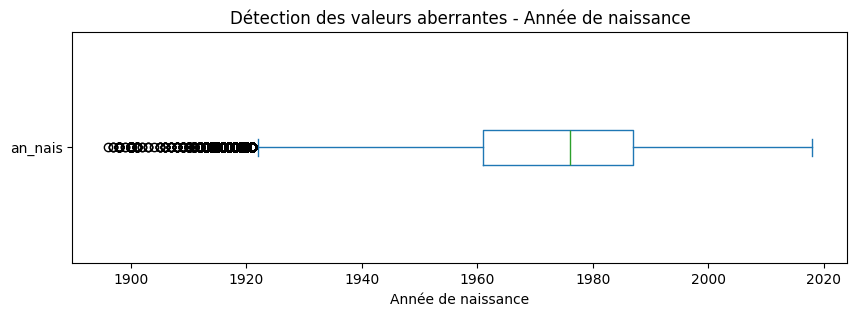

In [62]:
##On regarde s'il y a des valeurs aberrantes
plt.figure(figsize=(10,3))
usagers['an_nais'].dropna().astype(int).plot(kind='box', vert=False)
plt.xlabel("Année de naissance")
plt.title("Détection des valeurs aberrantes - Année de naissance")
plt.show()

__Commentaire :__ On remarque ici des valeurs aberrantes.

In [63]:
##On analyse les valeurs aberrantes
##On filtre les valeurs entre les bornes logiques pour une année de naissance
borne_basse = 1920
borne_haute = 2018

# Filtrer les valeurs aberrantes
outliers = usagers[(usagers['an_nais'] < borne_basse) | (usagers['an_nais'] > borne_haute)]

print(f"Nombre de valeurs aberrantes détectées : {len(outliers)}")
print("Répartition des valeurs aberrantes :")
print(outliers['an_nais'].value_counts().sort_index())

# Afficher quelques exemples de lignes aberrantes
display(outliers.tail(10))

Nombre de valeurs aberrantes détectées : 3481
Répartition des valeurs aberrantes :
an_nais
1896      1
1897      3
1898     35
1899      2
1900    138
1901     37
1902      2
1903      3
1904      1
1905      5
1906      8
1907      8
1908     13
1909     32
1910     72
1911     83
1912    121
1913    176
1914    285
1915    238
1916    277
1917    421
1918    573
1919    947
Name: count, dtype: Int64


,Num_Acc,place,catu,grav,trajet,secu,an_nais,annee,Homme,Femme,pieton,Arrière,Autre,Avant,Conducteur,trajet_grp
2030867,201800008010,1.0,1,3,0.0,1,1918,2018,1,0,0,0,0,0,1,Inconnu
2032233,201800008624,NaN,3,4,5.0,-1,1919,2018,1,0,1,0,1,0,0,Loisirs
2064700,201800023257,NaN,3,4,5.0,-1,1916,2018,0,1,1,0,1,0,0,Loisirs
2096879,201800037624,9.0,2,4,1.0,-1,1919,2018,0,1,0,0,1,0,0,Travail
2099072,201800038667,1.0,1,1,4.0,1,1918,2018,1,0,0,0,0,0,1,Professionnel
2115643,201800046023,1.0,1,4,0.0,1,1917,2018,1,0,0,0,0,0,1,Inconnu
2117708,201800046861,2.0,2,4,5.0,1,1919,2018,0,1,0,0,0,1,0,Loisirs
2122060,201800048775,4.0,2,1,5.0,1,1918,2018,0,1,0,1,0,0,0,Loisirs
2126250,201800050306,NaN,3,4,5.0,-1,1918,2018,0,1,1,0,1,0,0,Loisirs
2137208,201800055647,2.0,2,1,5.0,1,1911,2018,1,0,0,0,0,1,0,Loisirs


__Commentaire :__
- Des années comme 1910–1919 : pas impossible (ça ferait des usagers de +100 ans mais reste très rare)
- Des années comme 1896, 1900 : Improbables, on peut considérer que ce sont des erreurs de saisie.

In [64]:
##Question, est-ce qu'on peut remplacer les valeurs abberantes en supposant une erreur de saisie ?
# Année de référence
usagers_copy = usagers.copy()
annee_ref = usagers_copy['annee']

# Correction : ajouter 100 ans si année entre 1800 et 1900
def correct_year(x):
    if 1800 < x < 1900:
        return x + 100
    return x

usagers_copy['an_nais_corr'] = usagers_copy['an_nais'].apply(correct_year)

# Calcul des âges brut et corrigé
usagers_copy['age_brut'] = annee_ref - usagers_copy['an_nais']
usagers_copy['age_corr'] = annee_ref - usagers_copy['an_nais_corr']

# Afficher un aperçu sur les cas suspects
suspects = usagers_copy[usagers_copy['an_nais'] < 1900][['annee','an_nais','an_nais_corr','age_brut','age_corr']]
print(suspects.tail(20))

# Filtrer les cas suspects corrigés ET conducteurs
suspects_conducteurs = usagers_copy[
    (usagers_copy['an_nais'] < 1900) & (usagers_copy['catu'] == 1)][['annee','an_nais','an_nais_corr','age_brut','age_corr','catu']]

print(suspects_conducteurs.head(20))
print(f"Nombre total de conducteurs concernés : {len(suspects_conducteurs)}")

        annee  an_nais  an_nais_corr  age_brut  age_corr
221857   2006     1897        1997.0       109       9.0
256041   2006     1898        1998.0       108       8.0
261562   2006     1898        1998.0       108       8.0
263820   2006     1898        1998.0       108       8.0
327349   2006     1898        1998.0       108       8.0
337274   2006     1897        1997.0       109       9.0
346394   2006     1898        1998.0       108       8.0
353557   2006     1898        1998.0       108       8.0
384492   2006     1898        1998.0       108       8.0
392318   2007     1898        1998.0       109       9.0
437308   2007     1898        1998.0       109       9.0
467308   2007     1898        1998.0       109       9.0
469413   2007     1898        1998.0       109       9.0
499718   2007     1898        1998.0       109       9.0
502681   2007     1898        1998.0       109       9.0
508862   2007     1898        1998.0       109       9.0
532646   2007     1898        1

__Commentaire :__
ce n'est donc pas possible de remplacer les valeurs aberrantes en supposant une erreur de saisie, puisque les usagers sont des conducteurs. Hors on ne peut pas être conducteur à 8ans.

In [65]:
##On nettoie
##Je passe les valeurs aberrantes en Nans

BORNE_BASSE = 1920
BORNE_HAUTE = 2018

# On crée une nouvelle colonne nettoyée
usagers['an_nais_clean'] = usagers['an_nais'].where(
    usagers['an_nais'].between(BORNE_BASSE, BORNE_HAUTE),
    np.nan
)

# Vérification : nombre de NaN créés
print("Nombre de valeurs aberrantes transformées en NaN :", usagers['an_nais_clean'].isna().sum())

# Aperçu des colonnes
print(usagers[['an_nais','an_nais_clean']].head(20))

Nombre de valeurs aberrantes transformées en NaN : 5899
    an_nais  an_nais_clean
0      1976           1976
1      1968           1968
2      1964           1964
3      2004           2004
4      1998           1998
5      1991           1991
6      1955           1955
7      1979           1979
8      1983           1983
9      1956           1956
10     1920           1920
11     1923           1923
12     1964           1964
13     1972           1972
14     1949           1949
15     1990           1990
16     1951           1951
17     1983           1983
18     1965           1965
19     1978           1978


In [66]:
##On regarde combien on a de Nans

total = len(usagers)

# Nombre de NaN
nb_nan = usagers['an_nais_clean'].isna().sum()

# Proportion
pct_nan = (nb_nan / total) * 100

print("Taille du dataset :", total)
print("Valeurs NaN (aberrantes remplacées) :", nb_nan)
print(f"Proportion de NaN : {pct_nan:.2f}%")


Taille du dataset : 2142195
Valeurs NaN (aberrantes remplacées) : 5899
Proportion de NaN : 0.28%


__Commentaire :__ Nous avons moins d'un % de Nans, on va donc le remplacer par l'âge courant.

In [67]:
# Calculer âge courant
usagers['age'] = usagers['annee'] - usagers['an_nais_clean']

#  Détecter les NaN (aberrantes)
mask_aberrantes = usagers['an_nais_clean'].isna()

# Médiane de l’âge
median_age = int(usagers['age'].median())
print("Âge médian courant :", median_age)

# Imputer aléatoirement autour de la médiane [median-5 ; median+5]
usagers['age_imputed'] = usagers['age'].copy()
usagers.loc[mask_aberrantes, 'age_imputed'] = np.random.randint(
    median_age - 5,
    median_age + 6,
    size=mask_aberrantes.sum())

# Recalculer année de naissance finale
usagers['an_nais_final'] = (usagers['annee'] - usagers['age_imputed']).astype('Int64')

# Vérification
print("Valeurs imputées :", mask_aberrantes.sum())
print(usagers.loc[mask_aberrantes, ['annee','an_nais','an_nais_clean','age_imputed','an_nais_final']].head(20))

Âge médian courant : 34
Valeurs imputées : 5899
      annee  an_nais  an_nais_clean  age_imputed  an_nais_final
437    2005     1915           <NA>           31           1974
505    2005     1917           <NA>           33           1972
529    2005     1919           <NA>           30           1975
599    2005     1919           <NA>           31           1974
770    2005     1919           <NA>           38           1967
786    2005     <NA>           <NA>           34           1971
787    2005     <NA>           <NA>           34           1971
872    2005     1916           <NA>           32           1973
915    2005     1919           <NA>           38           1967
1157   2005     1918           <NA>           38           1967
1247   2005     1919           <NA>           29           1976
1854   2005     1917           <NA>           32           1973
2018   2005     1915           <NA>           35           1970
2417   2005     1919           <NA>           35        

In [68]:
# On crée des classes par tranche d'âge
usagers['age'] = usagers['annee'] - usagers['an_nais']

def age_group(age):
    if age < 18:
        return "Enfant"
    elif age < 30:
        return "Jeune"
    elif age < 60:
        return "Adulte"
    else:
        return "Senior"

usagers['age_grp'] = usagers['age'].apply(age_group)

In [69]:
usagers.head()

,Num_Acc,place,catu,grav,trajet,secu,an_nais,annee,Homme,Femme,...,Arrière,Autre,Avant,Conducteur,trajet_grp,an_nais_clean,age,age_imputed,an_nais_final,age_grp
0,200500000001,1.0,1,4,1.0,1,1976,2005,1,0,...,0,0,0,1,Travail,1976,29,29,1976,Jeune
1,200500000001,1.0,1,3,3.0,1,1968,2005,0,1,...,0,0,0,1,Autre,1968,37,37,1968,Adulte
2,200500000001,2.0,2,1,0.0,1,1964,2005,1,0,...,0,0,1,0,Inconnu,1964,41,41,1964,Adulte
3,200500000001,4.0,2,1,0.0,3,2004,2005,1,0,...,1,0,0,0,Inconnu,2004,1,1,2004,Enfant
4,200500000001,5.0,2,1,0.0,1,1998,2005,1,0,...,1,0,0,0,Inconnu,1998,7,7,1998,Enfant


###### <font color="purple"> &nbsp;&nbsp;&nbsp;-- *Variable grav*  -- </font>

__Commentaire :__ Il faut maintenant analyser la gravité pour n'avoir qu'une ligne par accident.

In [70]:
print(usagers.isna().sum())
print(usagers['grav'].value_counts(dropna=False))

##Il n'y a pas de Nans ou de valeurs aberrantes sur la colonne 'grav'

Num_Acc               0
place            123128
catu                  0
grav                  0
trajet              494
secu                  0
an_nais            2418
annee                 0
Homme                 0
Femme                 0
pieton                0
Arrière               0
Autre                 0
Avant                 0
Conducteur            0
trajet_grp            0
an_nais_clean      5899
age                2418
age_imputed           0
an_nais_final         0
age_grp               0
dtype: int64
grav
1    875392
4    764391
3    444831
2     57581
Name: count, dtype: int64


In [71]:
# Codes attendus : 1 = Indemne, 2 = Tué, 3 = Blessé hospitalisé, 4 = Blessé léger
label_grav = {1:"Indemne", 2:"Tué", 3:"Blessé hospitalisé", 4:"Blessé léger"}
ordre_gravite = {1:0, 4:1, 3:2, 2:3}  # échelle: indemne < léger < hosp < tué

usagers_ter = usagers.copy()

# Colonnes indicatrices par usager
usagers_ter['tue']   = (usagers_ter['grav'] == 2).astype(int)
usagers_ter['hosp']  = (usagers_ter['grav'] == 3).astype(int)
usagers_ter['leger'] = (usagers_ter['grav'] == 4).astype(int)
usagers_ter['indem'] = (usagers_ter['grav'] == 1).astype(int)

# Gravité max
usagers_ter['grav_order'] = usagers_ter['grav'].map(ordre_gravite)

# Gravité max + comptage tués par accident
#accidents = u.groupby('Num_Acc').agg(
    #grav_order_max = ('grav_order', 'max'),
    #n_usagers      = ('grav', 'size'),
    #n_tues         = ('has_tue', 'sum'),
    #n_hosp         = ('has_hosp', 'sum'),
    #n_legers       = ('has_leger', 'sum'),
    #n_indemnes     = ('has_indem', 'sum'),
accidents = usagers_ter.groupby('Num_Acc').agg(
    grav_order_max = ('grav_order', 'max'),
#    n_usagers      = ('grav', 'size'),
#    n_tues         = ('tue', 'sum'),
#    n_hosp         = ('hosp', 'sum'),
#    n_legers       = ('leger', 'sum'),
#    n_indemnes     = ('indem', 'sum'),
).reset_index()

print(accidents.head())


        Num_Acc  grav_order_max
0  200500000001               2
1  200500000002               2
2  200500000003               2
3  200500000004               2
4  200500000005               2


<font color="blue">__Remarque Philippe:__ </font>
- petite typo corrigée (accidents = u.)
- fusion de accidents avec usagers

In [72]:
##On supprime les colonnes inutiles à la fin
usagers = usagers.drop(['place','catu'], axis=1)

<font color="red">__Ce qu'il reste à faire ?__
- Regarder si pas disparité dans variable grav, exemple de pourcentages de classes trop différents (oversampling etc...si nécessaire)
- suppr place, catu et toutes les colonnes qui ne servent plus
- Est-ce qu'il y a encore des nans etc... ? </font>

<font color="blue">__Philippe__</font>
- colonnes inutiles
    - "annee", "an_nais", "an_nais_clean", "an_nais_final", "age", "age_imputed" si on utilise "age_grp")
    - "trajet, "Homme", "Femme" si on utilise "trajet_grp" et "pres_Homme/Femme"
    - "sexe" si on utilise sexe_acc
    - nb_usagers très corrélés avec la somme des autres variables nb_*
- appliquer un get_dummies sur age_grp

In [73]:
usagers.columns


Index(['Num_Acc', 'grav', 'trajet', 'secu', 'an_nais', 'annee', 'Homme',
       'Femme', 'pieton', 'Arrière', 'Autre', 'Avant', 'Conducteur',
       'trajet_grp', 'an_nais_clean', 'age', 'age_imputed', 'an_nais_final',
       'age_grp'],
      dtype='object')

In [74]:
sexe_acc.columns

Index(['Num_Acc', 'pres_Homme', 'pres_Femme'], dtype='object')

In [75]:
usagers_final = usagers.drop(["annee", "an_nais", "an_nais_clean", "an_nais_final", "age", "age_imputed"], axis=1)
usagers_final = usagers_final.merge(sexe_acc, on="Num_Acc", how="left")

usagers_final = usagers_final.drop(["trajet", "Homme", "Femme"], axis=1)

usagers_final = pd.get_dummies(usagers_final, columns=["age_grp", "trajet_grp"], drop_first=False) # Faudra supprimer une modalité par la suite pour éviter la colinéarité


In [76]:
usagers_final.head()

,Num_Acc,grav,secu,pieton,Arrière,Autre,Avant,Conducteur,pres_Homme,pres_Femme,age_grp_Adulte,age_grp_Enfant,age_grp_Jeune,age_grp_Senior,trajet_grp_Autre,trajet_grp_Inconnu,trajet_grp_Loisirs,trajet_grp_Professionnel,trajet_grp_Travail
0,200500000001,4,1,0,0,0,0,1,2,2,False,False,True,False,False,False,False,False,True
1,200500000001,3,1,0,0,0,0,1,2,2,True,False,False,False,True,False,False,False,False
2,200500000001,1,1,0,0,0,1,0,2,2,True,False,False,False,False,True,False,False,False
3,200500000001,1,3,0,1,0,0,0,2,2,False,True,False,False,False,True,False,False,False
4,200500000001,1,1,0,1,0,0,0,2,2,False,True,False,False,False,True,False,False,False


<font color="blue">__Philippe__</font>
- NaN

In [77]:
usagers_final.isna().sum()

Num_Acc                     0
grav                        0
secu                        0
pieton                      0
Arrière                     0
Autre                       0
Avant                       0
Conducteur                  0
pres_Homme                  0
pres_Femme                  0
age_grp_Adulte              0
age_grp_Enfant              0
age_grp_Jeune               0
age_grp_Senior              0
trajet_grp_Autre            0
trajet_grp_Inconnu          0
trajet_grp_Loisirs          0
trajet_grp_Professionnel    0
trajet_grp_Travail          0
dtype: int64

==> Il n'y a plus de NaN !!

In [78]:
usagers_final["grav_order"] = usagers_final["grav"].map(ordre_gravite)

# Gravité max par accident
#grav_max_df = usagers_final.groupby("Num_Acc")["grav_order"].max().reset_index(name="grav_order_max")
print("usagers:", len(usagers.Num_Acc.unique()))
print("usagers_final:", len(usagers_final.Num_Acc.unique()))
# Aggrégation par accident
usagers_agg_acc = usagers_final.groupby("Num_Acc").agg({
    "grav_order": "max",
    "secu": "min", ### Pb ###
    "pieton": "sum",
    "Conducteur": "sum",
    "Autre": "sum",
    "Arrière": "sum",
    "Avant": "sum",
    "pres_Homme": "max",
    "pres_Femme": "max",
    "age_grp_Enfant": "sum",
    "age_grp_Adulte": "sum",
    "age_grp_Jeune": "sum",
    "age_grp_Senior": "sum",
    "trajet_grp_Autre": "sum",
    "trajet_grp_Inconnu": "sum",
    "trajet_grp_Loisirs": "sum",
    "trajet_grp_Professionnel": "sum",
    "trajet_grp_Travail": "sum"
}).reset_index()
usagers_agg_acc.head()
print("usagers_agg_acc:", len(usagers_agg_acc.Num_Acc.unique()))

usagers: 958469
usagers_final: 958469
usagers_agg_acc: 958469


<font color="red" size=3> __Avec cette aggrégation, la variable secu (et d'autres?) n'est plus exploitable!__</font>

In [79]:
usagers_agg_acc = usagers_agg_acc.merge(accidents, on="Num_Acc", how="left")
usagers_agg_acc = usagers_agg_acc.drop("grav_order_max", axis=1)

usagers_agg_acc.head()

,Num_Acc,grav_order,secu,pieton,Conducteur,Autre,Arrière,Avant,pres_Homme,pres_Femme,age_grp_Enfant,age_grp_Adulte,age_grp_Jeune,age_grp_Senior,trajet_grp_Autre,trajet_grp_Inconnu,trajet_grp_Loisirs,trajet_grp_Professionnel,trajet_grp_Travail
0,200500000001,2,1,0,2,0,3,1,2,2,3,2,1,0,1,4,0,0,1
1,200500000002,2,1,0,2,0,0,0,2,0,0,1,1,0,0,0,2,0,0
2,200500000003,2,2,0,2,0,0,0,2,0,0,1,1,0,0,0,0,0,2
3,200500000004,2,1,0,3,0,0,1,2,2,0,2,0,2,1,1,1,0,1
4,200500000005,2,1,0,1,0,0,1,2,0,1,1,0,0,0,1,1,0,0



<font color="blue">__Philippe__</font>
- Disparité grav

In [80]:
accidents['grav_order_max'].value_counts(normalize=True).sort_index()


grav_order_max
1    0.563792
2    0.380689
3    0.055519
Name: proportion, dtype: float64

=> Classe 3 (tué) très minoritaire (~5,6%) -> pb pour les modèles de classification
    => Besoin d'appliquer un oversampling / SMOTE (après le split)

## lieux

##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *importation fichiers*  -- </font>

In [81]:
lieux_2005_2018 = []

for annee in range(2005, 2019):
    chemin = f'C:/Users/enora/Documents/01_Data_scientest/Projet_accident/Data_gouv_2005_2019/lieux_{annee}.csv'
    chemin = f'data/lieux_{annee}.csv' ## chemin Philippe

    df = pd.read_csv(chemin, sep=',', encoding='latin1', dtype={'voie': str})
    df['annee'] = annee
    lieux_2005_2018.append(df)

lieux = pd.concat(lieux_2005_2018, ignore_index=True)

lieux.head()

,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1,annee
0,200500000001,3.0,00041,0.0,B,2.0,2.0,1.0,430.0,0.0,1.0,1.0,0.0,63.0,1.0,0.0,1.0,0.0,2005
1,200500000002,2.0,00041,0.0,NaN,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,100.0,1.0,0.0,5.0,0.0,2005
2,200500000003,2.0,00041,0.0,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,5.0,0.0,2005
3,200500000004,3.0,00916,0.0,NaN,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2005
4,200500000005,3.0,00110,0.0,NaN,2.0,2.0,24.0,630.0,0.0,1.0,3.0,0.0,59.0,2.0,0.0,3.0,0.0,2005


##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *première analyse*  -- </font>

In [82]:
# infos générales
display(lieux.info())

display(lieux.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958469 entries, 0 to 958468
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Num_Acc  958469 non-null  int64  
 1   catr     958468 non-null  float64
 2   voie     869558 non-null  object 
 3   v1       333391 non-null  float64
 4   v2       39348 non-null   object 
 5   circ     956895 non-null  float64
 6   nbv      955738 non-null  float64
 7   pr       482985 non-null  float64
 8   pr1      481166 non-null  float64
 9   vosp     955708 non-null  float64
 10  prof     956520 non-null  float64
 11  plan     956188 non-null  float64
 12  lartpc   902271 non-null  float64
 13  larrout  904096 non-null  float64
 14  surf     956545 non-null  float64
 15  infra    953061 non-null  float64
 16  situ     953499 non-null  float64
 17  env1     953029 non-null  float64
 18  annee    958469 non-null  int64  
dtypes: float64(15), int64(2), object(2)
memory usage: 138.9+ MB


None

,Num_Acc,catr,v1,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1,annee
count,9.584690e+05,958468.000000,333391.000000,956895.000000,955738.000000,482985.000000,481166.000000,955708.000000,956520.000000,956188.000000,902271.000000,904096.000000,956545.000000,953061.000000,953499.000000,953029.000000,958469.000000
mean,2.010936e+11,3.405169,0.072036,1.858706,2.067294,97.840662,280.298820,0.132023,1.145464,1.199649,5.307585,57.931692,1.258323,0.439104,1.193120,38.230840,2010.935366
std,4.070173e+08,1.202907,0.573331,0.721072,1.522966,464.851138,356.963732,0.557569,0.614779,0.723870,23.056452,64.607800,0.950038,1.350601,0.769613,48.059472,4.070223
min,2.005000e+11,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-81.000000,0.000000,0.000000,0.000000,0.000000,2005.000000
25%,2.007001e+11,3.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2007.000000
50%,2.011000e+11,4.000000,0.000000,2.000000,2.000000,6.000000,100.000000,0.000000,1.000000,1.000000,0.000000,60.000000,1.000000,0.000000,1.000000,0.000000,2011.000000
75%,2.014001e+11,4.000000,0.000000,2.000000,2.000000,27.000000,500.000000,0.000000,1.000000,1.000000,0.000000,80.000000,1.000000,0.000000,1.000000,99.000000,2014.000000
max,2.018001e+11,9.000000,9.000000,4.000000,99.000000,9929.000000,9540.000000,3.000000,4.000000,4.000000,960.000000,999.000000,9.000000,7.000000,5.000000,99.000000,2018.000000


In [83]:
# surf: Etat de la surface :
# Normal = 1
#    1 – Normale
#    2 – Mouillée
# Défavorable = 0
#    3 – Flaques
#    4 – Inondée
#    5 – Enneigée
#    6 – Boue
#    7 – Verglacée
#    8 – Corps gras – huile
# Inconnu = -1
#     -1 – Non renseigné
#     9– Autre

lieux["surf"] = np.where(lieux["surf"].isin([1, 2]), "1",
                   np.where(lieux["surf"].isin([3, 4, 5, 6, 7, 8]), "0", "-1"))

In [84]:
#On regarde les valeurs nulles
val_nul = lieux.isna().sum()
print("\nvaleurs nulles :\n", val_nul)

#On regarde les doublons
doublons = lieux['Num_Acc'].duplicated().sum()
print("\nIl y a", doublons, "doublons dans Num_Acc \n")


valeurs nulles :
 Num_Acc         0
catr            1
voie        88911
v1         625078
v2         919121
circ         1574
nbv          2731
pr         475484
pr1        477303
vosp         2761
prof         1949
plan         2281
lartpc      56198
larrout     54373
surf            0
infra        5408
situ         4970
env1         5440
annee           0
dtype: int64

Il y a 0 doublons dans Num_Acc 



__Commentaire :__
- catr -> on supprime nan
- nbv, prof, surf -> on supprime nan
- situ : on remplace par -1 -> pas renseigné

- vosp : pas très interessant
- v1, v2, pr et pr1 -: trop de valeurs manquantes pour être exploitable
- plan : pas interessant
- env1 : on supprime

In [85]:
##On supprime les colonnes qui ne sont pas exploitables
lieux.drop(['vosp', 'v1', 'v2', 'pr', 'pr1', 'plan', 'env1'], axis = 1, inplace = True)

In [86]:
lieux.dropna(subset=['catr'], inplace=True)

In [87]:
#On regarde les valeurs nulles
val_nul = lieux.isna().sum()
print("\nvaleurs nulles :\n", val_nul)


valeurs nulles :
 Num_Acc        0
catr           0
voie       88911
circ        1574
nbv         2731
prof        1949
lartpc     56198
larrout    54373
surf           0
infra       5408
situ        4970
annee          0
dtype: int64


In [88]:
lieux.head()

,Num_Acc,catr,voie,circ,nbv,prof,lartpc,larrout,surf,infra,situ,annee
0,200500000001,3.0,00041,2.0,2.0,1.0,0.0,63.0,1,0.0,1.0,2005
1,200500000002,2.0,00041,0.0,2.0,1.0,0.0,100.0,1,0.0,5.0,2005
2,200500000003,2.0,00041,0.0,0.0,1.0,0.0,0.0,1,0.0,5.0,2005
3,200500000004,3.0,00916,2.0,2.0,1.0,0.0,0.0,1,0.0,1.0,2005
4,200500000005,3.0,00110,2.0,2.0,1.0,0.0,59.0,1,0.0,3.0,2005


<font color="blue"> Philippe </font>
- Voie: "Numero de la route" => on supprime
- Annee: on supprime car info dispo dans la date + Num_Acc
- les autres variables peuvent être intéressantes => on les garde et on impute -1
  

In [89]:
lieux = lieux.drop(["voie", "annee"], axis=1)
lieux = lieux.fillna(-1)

<font color="red">__Commentaire__ :
Il faudrait fusionner les dataSet pour pouvoir analyser les nans restants et les variables en fonction de la Var gravité</font>

## Vehicules - clean

##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *importation fichiers*  --

In [90]:
vehicules_2005_2018 = []

for annee in range(2005, 2019):
    chemin = f'C:/Users/enora/Documents/01_Data_scientest/Projet_accident/Data_gouv_2005_2019/vehicules_{annee}.csv'
    chemin = f'data/vehicules_{annee}.csv' ## chemin Philippe

    df = pd.read_csv(chemin, sep=',', encoding='latin1')

    df['annee'] = annee
    vehicules_2005_2018.append(df)

vehicules = pd.concat(vehicules_2005_2018, ignore_index=True)
vehicules.head()

,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,num_veh,annee
0,200500000001,0.0,7,0,0.0,2.0,1.0,1.0,A01,2005
1,200500000001,0.0,7,0,0.0,2.0,8.0,10.0,B02,2005
2,200500000002,0.0,7,0,0.0,2.0,7.0,16.0,A01,2005
3,200500000002,0.0,2,0,0.0,2.0,1.0,1.0,B02,2005
4,200500000003,0.0,2,0,0.0,2.0,1.0,1.0,A01,2005


##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *première analyse*  -- </font>

In [91]:
# infos générales
display(vehicules.info())

display(vehicules.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635811 entries, 0 to 1635810
Data columns (total 10 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Num_Acc  1635811 non-null  int64  
 1   senc     1635539 non-null  float64
 2   catv     1635811 non-null  int64  
 3   occutc   1635811 non-null  int64  
 4   obs      1634805 non-null  float64
 5   obsm     1635033 non-null  float64
 6   choc     1635414 non-null  float64
 7   manv     1635343 non-null  float64
 8   num_veh  1635811 non-null  object 
 9   annee    1635811 non-null  int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 124.8+ MB


None

,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,annee
count,1.635811e+06,1.635539e+06,1.635811e+06,1.635811e+06,1.634805e+06,1.635033e+06,1.635414e+06,1.635343e+06,1.635811e+06
mean,2.010928e+11,2.314650e-01,1.160370e+01,7.982340e-02,9.172238e-01,1.582926e+00,2.897650e+00,6.045541e+00,2.010927e+03
std,4.076439e+08,5.510318e-01,1.138438e+01,2.225429e+00,2.995118e+00,1.229925e+00,2.463939e+00,7.182376e+00,4.076487e+00
min,2.005000e+11,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.005000e+03
25%,2.007001e+11,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.007000e+03
50%,2.011000e+11,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.011000e+03
75%,2.014001e+11,0.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,1.300000e+01,2.014000e+03
max,2.018001e+11,2.000000e+00,9.900000e+01,9.000000e+02,1.600000e+01,9.000000e+00,9.000000e+00,2.400000e+01,2.018000e+03


In [92]:
#On regarde les valeurs nulles
val_nul = vehicules.isna().sum()
print("\nvaleurs nulles :\n", val_nul)


valeurs nulles :
 Num_Acc       0
senc        272
catv          0
occutc        0
obs        1006
obsm        778
choc        397
manv        468
num_veh       0
annee         0
dtype: int64


In [93]:
## Je verifie qu'il n'y a pas d'explication particulière au Nan de obs et obsm
print(vehicules[vehicules['obs'].isna()]['catv'].value_counts())
print(vehicules[vehicules['obsm'].isna()]['catv'].value_counts())

catv
7     670
1      72
10     52
33     52
30     27
99     24
2      23
15     18
14     14
17      9
31      8
32      8
34      6
37      6
13      5
38      3
39      3
3       3
40      1
36      1
20      1
Name: count, dtype: int64
catv
7     470
1      66
33     55
10     45
2      25
30     19
14     18
31     18
99     13
32      9
15      8
17      8
34      5
13      5
38      4
37      3
21      2
3       2
39      2
36      1
Name: count, dtype: int64


__Commentaire :__

- Colonne senc (Sens de circulation) : je la supprimerais, pas sûre qu'elle soit utile. Mais un peu de mal à la comprendre donc pas sûre.
- obs et obsm : pas de raison particulière au Nan pour les colonnes obs et obsm. -> Je remplacerais par -1 (non renseigné)
- choc et manv : peu de valeurs nulles vu qu'on a plus d'un million de lignes, je les enlèverais.

In [94]:
## On remplace les Nans de obs et obm par -1
vehicules[['obs', 'obsm']] = vehicules[['obs', 'obsm']].fillna(-1)

##On vérifie
vehicules[['obs', 'obsm']].isna().sum()

obs     0
obsm    0
dtype: int64

In [95]:
## On supprime les nans de choc et manv et senc
vehicules = vehicules.dropna(subset=['choc', 'manv', 'senc'])

##On vérifie
val_nul = vehicules.isna().sum()
print("\nvaleurs nulles :\n", val_nul)


valeurs nulles :
 Num_Acc    0
senc       0
catv       0
occutc     0
obs        0
obsm       0
choc       0
manv       0
num_veh    0
annee      0
dtype: int64


In [96]:
#On regarde les doublons
doublons = vehicules['Num_Acc'].duplicated().sum()
print("\nIl y a", doublons, "doublons dans Num_Acc \n")


Il y a 676842 doublons dans Num_Acc 



Commentaire : liés aux accidents à plusieurs véhicules

##### <font color="sky blue"> &nbsp;&nbsp;&nbsp;-- *On prépare pour fusion*  -- </font>

In [97]:
##On souhaite étudier la gravité de l'accident
Test_vehicules = vehicules[vehicules['Num_Acc'] == '200600000001']
Test_vehicules.head()

#vehicules_gt3 = vehicules.groupby('Num_Acc').filter(lambda g: len(g) > 3)

,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,num_veh,annee


In [98]:
#vehicules_gt3.head(15)

Avis à faire :
On met num_veh en une seule ligne et on remplace par le nombre de véhicule

In [99]:
# On crée une colonne nb de véhicules par accident
vehicules['nb_veh'] = vehicules.groupby('Num_Acc')['num_veh'].transform('nunique')
vehicules.drop(columns=['num_veh'], inplace=True)
vehicules.head()

,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,annee,nb_veh
0,200500000001,0.0,7,0,0.0,2.0,1.0,1.0,2005,2
1,200500000001,0.0,7,0,0.0,2.0,8.0,10.0,2005,2
2,200500000002,0.0,7,0,0.0,2.0,7.0,16.0,2005,2
3,200500000002,0.0,2,0,0.0,2.0,1.0,1.0,2005,2
4,200500000003,0.0,2,0,0.0,2.0,1.0,1.0,2005,2


Pb : un même accident peut générer plusieurs lignes si plusieurs véhicules sont impliqués

In [100]:
vehicules.head()

,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,annee,nb_veh
0,200500000001,0.0,7,0,0.0,2.0,1.0,1.0,2005,2
1,200500000001,0.0,7,0,0.0,2.0,8.0,10.0,2005,2
2,200500000002,0.0,7,0,0.0,2.0,7.0,16.0,2005,2
3,200500000002,0.0,2,0,0.0,2.0,1.0,1.0,2005,2
4,200500000003,0.0,2,0,0.0,2.0,1.0,1.0,2005,2


In [101]:
##Colonne choc, on réduit le nombre de colonnes
## Créer les 4 familles directement
vehicules['choc_avant']    = vehicules['choc'].isin([1,2,3]).astype(int)
vehicules['choc_arriere']  = vehicules['choc'].isin([4,5,6]).astype(int)
vehicules['choc_lateral']  = vehicules['choc'].isin([7,8]).astype(int)
vehicules['choc_multiple'] = (vehicules['choc'] == 9).astype(int)

## Agréger pour avoir une ligne par accident
flags = (vehicules.groupby('Num_Acc', as_index=False)
                   [['choc_avant','choc_arriere','choc_lateral','choc_multiple']]
                   .max())

# Garde UNE ligne par accident pour les autres colonnes
vehicules_clean = (vehicules.drop(columns=['choc','choc_avant','choc_arriere','choc_lateral','choc_multiple'], errors='ignore')  # enlève la colonne brute choc
                              .drop_duplicates('Num_Acc', keep='first')
                              .merge(flags, on='Num_Acc', how='left'))

vehicules_clean.head()

,Num_Acc,senc,catv,occutc,obs,obsm,manv,annee,nb_veh,choc_avant,choc_arriere,choc_lateral,choc_multiple
0,200500000001,0.0,7,0,0.0,2.0,1.0,2005,2,1,0,1,0
1,200500000002,0.0,7,0,0.0,2.0,16.0,2005,2,1,0,1,0
2,200500000003,0.0,2,0,0.0,2.0,1.0,2005,2,1,0,0,0
3,200500000004,0.0,7,0,0.0,2.0,13.0,2005,3,1,0,1,0
4,200500000005,0.0,7,0,6.0,0.0,1.0,2005,1,0,0,1,0


## On fusionne

In [102]:
#<font color="red">C'était le code quez j'avais utilisé pour tout fusionner</font>
# correction des noms "finaux" des df (vehicules_clean, usagers_final)

# S'assurer que la clé est au bon format partout
caracs['Num_Acc'] = caracs['Num_Acc'].astype(str)
vehicules_clean['Num_Acc'] = vehicules_clean['Num_Acc'].astype(str)
usagers_final['Num_Acc'] = usagers_final['Num_Acc'].astype(str)
usagers_agg_acc['Num_Acc'] = usagers_agg_acc['Num_Acc'].astype(str)

lieux['Num_Acc'] = lieux['Num_Acc'].astype(str)



## Analyse de la gravité

<font color="red">Pour rappel, on veut étudier la gravité de l'accident. On a la variable cible "grav"
En dessous ce sont des codes que j'avais commencé à faire, mais je ne les ai pas lancé donc peut être que ça ne fonctionne plus avec mes modifications plus haut.</font>

##On souhaite étudier la gravité de l'accident
Test_Num_Acc = df_merge[df_merge['Num_Acc'] == '200500000001']

### On compte le nombre d'occurrences de chaque valeur dans chaque colonne
for col in Test_Num_Acc.columns:
    if Test_Num_Acc[col].nunique() > 1:  # Plus d'une valeur différente
        print(f"\n--- {col} ---")
        print(Test_Num_Acc[col].value_counts())


##On supprime colonnes en doubles ou inutiles
df_merge.drop('num_veh_usag', axis = 1)

df_merge.isna().sum()

### Test
### Fusionner dans l'ordre souhaité, caracs à gauche


df_merge_test1 = caracs \
    .merge(vehicules, on='Num_Acc', how='left', suffixes=('', '_veh'))

df_merge_test2 = vehicules \
    .merge(usagers, on='Num_Acc', how='left', suffixes=('', '_usag'))

df_merge_test3 = vehicules \
    .merge(lieux, on='Num_Acc', how='left', suffixes=('', '_lieu'))
    
print(df_merge_test1.isna().sum())
print(df_merge_test2.isna().sum())
print(df_merge_test3.isna().sum())

cles_uniques_vehicules = set(vehicules['Num_Acc']) - set(caracs['Num_Acc'])
print(f"Clés présentes seulement dans vehicules : {len(cles_uniques_vehicules)}")
print(list(cles_uniques_vehicules)[:10])  # un aperçu

#### Clés présentes dans autre_df mais absentes dans vehicules
cles_uniques_autre = set(caracs['Num_Acc']) - set(vehicules['Num_Acc'])
print(f"Clés présentes seulement dans caracs : {len(cles_uniques_autre)}")
print(list(cles_uniques_autre)[:10])  # un aperçu

## <font color="blue"><u> __> Analyse suivant un axe "accident"__ </font>
- Dans ce cas d'analyse, on utilise le dataset aggrégé usagers_agg_acc pour la fusion

In [103]:
# Fusionner dans l'ordre souhaité, caracs à gauche
df_merge_accident = caracs \
    .merge(vehicules_clean, on='Num_Acc', how='left', suffixes=('', '_veh')) \
    .merge(usagers_agg_acc, on='Num_Acc', how='left', suffixes=('', '_usag')) \
    .merge(lieux, on='Num_Acc', how='left', suffixes=('', '_lieu'))

print(f"Lignes initiales (caracs) : {len(caracs)}")
print(f"Lignes finales (df_merge) : {len(df_merge_accident)}")
display(df_merge_accident.head())
print(df_merge_accident.columns)

Lignes initiales (caracs) : 929117
Lignes finales (df_merge) : 929117


,Num_Acc,lum,agg,int,atm,col,com,dep,date,moment,...,trajet_grp_Travail,catr,circ,nbv,prof,lartpc,larrout,surf,infra,situ
0,200500000001,3,2,1,1,3.0,011,590,2005-01-12,3,...,1,3.0,2.0,2.0,1.0,0.0,63.0,1,0.0,1.0
1,200500000002,1,2,1,1,1.0,051,590,2005-01-21,2,...,0,2.0,0.0,2.0,1.0,0.0,100.0,1,0.0,5.0
2,200500000003,3,1,1,1,1.0,051,590,2005-01-21,3,...,2,2.0,0.0,0.0,1.0,0.0,0.0,1,0.0,5.0
3,200500000004,1,1,1,1,5.0,082,590,2005-01-04,2,...,1,3.0,2.0,2.0,1.0,0.0,0.0,1,0.0,1.0
4,200500000005,3,1,1,0,6.0,478,590,2005-01-10,3,...,0,3.0,2.0,2.0,1.0,0.0,59.0,1,0.0,3.0


Index(['Num_Acc', 'lum', 'agg', 'int', 'atm', 'col', 'com', 'dep', 'date',
       'moment', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'manv', 'annee',
       'nb_veh', 'choc_avant', 'choc_arriere', 'choc_lateral', 'choc_multiple',
       'grav_order', 'secu', 'pieton', 'Conducteur', 'Autre', 'Arrière',
       'Avant', 'pres_Homme', 'pres_Femme', 'age_grp_Enfant', 'age_grp_Adulte',
       'age_grp_Jeune', 'age_grp_Senior', 'trajet_grp_Autre',
       'trajet_grp_Inconnu', 'trajet_grp_Loisirs', 'trajet_grp_Professionnel',
       'trajet_grp_Travail', 'catr', 'circ', 'nbv', 'prof', 'lartpc',
       'larrout', 'surf', 'infra', 'situ'],
      dtype='object')


In [104]:
df_merge_accident.isna().sum()
#df_merge_accident[df_merge_accident["pieton"].isna()]
#usagers_agg_acc[usagers_agg_acc["Num_Acc"]=="201000021002"]

Num_Acc                       0
lum                           0
agg                           0
int                           0
atm                           0
col                           0
com                           0
dep                           0
date                          0
moment                        0
senc                        239
catv                        239
occutc                      239
obs                         239
obsm                        239
manv                        239
annee                       239
nb_veh                      239
choc_avant                  239
choc_arriere                239
choc_lateral                239
choc_multiple               239
grav_order                    0
secu                          0
pieton                        0
Conducteur                    0
Autre                         0
Arrière                       0
Avant                         0
pres_Homme                    0
pres_Femme                    0
age_grp_

__Analyse des valeurs manquantes__

- Caracs vs usagers

In [105]:
usagers['Num_Acc'] = usagers['Num_Acc'].astype(str)

cles_uniques_caracs_usagers = set(caracs['Num_Acc']) - set(usagers_agg_acc['Num_Acc'])
print(f"Clés présentes seulement dans caracs vs usagers : {len(cles_uniques_caracs_usagers)}")
print(list(cles_uniques_caracs_usagers)[:10])  # un aperçu

print(len(caracs.Num_Acc.unique()))

print(len(usagers_agg_acc.Num_Acc.unique()))

Clés présentes seulement dans caracs vs usagers : 0
[]
929117
958469


In [106]:
cles_disparues_usagers = set(usagers['Num_Acc']) - set(usagers_agg_acc['Num_Acc'])
print(f"Clés perdues entre usagers et usagers_agg_acc : {len(cles_disparues_usagers)}")
print(list(cles_disparues_usagers)[:10])

Clés perdues entre usagers et usagers_agg_acc : 0
[]


In [107]:
usagers_perdus = usagers[usagers['Num_Acc'].isin(cles_disparues_usagers)]
print(usagers.shape)
print(usagers_perdus.shape)
usagers_perdus.head()

(2142195, 19)
(0, 19)


,Num_Acc,grav,trajet,secu,an_nais,annee,Homme,Femme,pieton,Arrière,Autre,Avant,Conducteur,trajet_grp,an_nais_clean,age,age_imputed,an_nais_final,age_grp


<u> Conclusion</u>: __Plus aucun écart entre les 2 datasets => Problème résolu!__

- Caracs vs vehicules

In [108]:
cles_uniques_caracs_vehicule = set(caracs['Num_Acc']) - set(vehicules_clean['Num_Acc'])
print(f"Clés présentes seulement dans caracs vs vehicules_clean : {len(cles_uniques_caracs_vehicule)}")
print(list(cles_uniques_caracs_vehicule)[:10])  # un aperçu

print(len(caracs.Num_Acc.unique()))

print(len(vehicules_clean.Num_Acc.unique()))

Clés présentes seulement dans caracs vs vehicules_clean : 239
['201800013420', '200900060638', '201200052572', '201700058110', '201800028021', '201800040996', '201800010556', '201500018429', '201200048078', '201800019691']
929117
958219


In [109]:
vehicules['Num_Acc'] = vehicules['Num_Acc'].astype(str)
vehicules_clean['Num_Acc'] = vehicules_clean['Num_Acc'].astype(str)

cles_disparues_vehicules = set(vehicules['Num_Acc']) - set(vehicules_clean['Num_Acc'])
print(f"Clés perdues entre vehicules et vehicules_clean : {len(cles_disparues_vehicules)}")
print(list(cles_disparues_vehicules)[:10])

vehicules_perdus = vehicules[vehicules['Num_Acc'].isin(cles_disparues_vehicules)]
print(vehicules.shape)
print(vehicules_perdus.shape)
vehicules_perdus.head()

Clés perdues entre vehicules et vehicules_clean : 0
[]
(1635061, 14)
(0, 14)


,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,annee,nb_veh,choc_avant,choc_arriere,choc_lateral,choc_multiple


In [110]:
df_merge_accident[df_merge_accident["senc"].isna()].T

,325076,328583,329291,334950,336117,340553,340555,349339,349348,349954,...,922782,922969,923017,923117,923149,923292,923466,923467,923542,927897
Num_Acc,200900004487,200900007994,200900008702,200900014362,200900015529,200900019966,200900019968,200900028752,200900028761,200900029369,...,201800049432,201800049619,201800049667,201800049767,201800049799,201800049942,201800050116,201800050117,201800050192,201800054547
lum,1,5,1,1,1,3,3,1,1,1,...,4,1,1,3,1,3,1,1,5,1
agg,2,2,2,2,2,1,1,2,2,2,...,1,1,2,1,1,1,1,1,1,2
int,1,2,3,3,1,1,1,1,1,4,...,1,1,1,1,1,1,1,1,1,1
atm,1,1,1,1,1,-1,-1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
col,6.0,6.0,1.0,3.0,6.0,5.0,5.0,6.0,6.0,6.0,...,6.0,6.0,6.0,7.0,4.0,5.0,7.0,7.0,6.0,6.0
com,585,63,280,392,1,278,122,18,219,387,...,283,047,055,026,071,001,085,055,055,119
dep,950,400,950,950,470,690,690,950,950,690,...,690,830,130,130,130,130,130,130,130,750
date,2009-01-22 00:00:00,2009-01-23 00:00:00,2009-02-27 00:00:00,2009-03-21 00:00:00,2009-04-28 00:00:00,2009-01-14 00:00:00,2009-01-14 00:00:00,2009-07-09 00:00:00,2009-07-17 00:00:00,2009-03-05 00:00:00,...,2018-08-23 00:00:00,2018-12-18 00:00:00,2018-01-29 00:00:00,2018-03-28 00:00:00,2018-04-19 00:00:00,2018-07-10 00:00:00,2018-11-13 00:00:00,2018-11-13 00:00:00,2018-12-16 00:00:00,2018-09-26 00:00:00
moment,2,3,2,2,3,1,1,2,1,1,...,4,2,1,3,2,3,1,1,3,2


In [111]:
vehicules[vehicules["Num_Acc"]=="200900007994"]

,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,annee,nb_veh,choc_avant,choc_arriere,choc_lateral,choc_multiple


<u> Conclusion</u>: __Pas de pattern identifié expliquant l'absence d'information sur le véhicule pour ces 55 888 accidents (6%)!__

- Absence d'information (lieux) pour un accident

In [112]:
df_merge_accident[df_merge_accident["situ"].isna()]

,Num_Acc,lum,agg,int,atm,col,com,dep,date,moment,...,trajet_grp_Travail,catr,circ,nbv,prof,lartpc,larrout,surf,infra,situ
68511,200500068514,3,1,1,1,6.0,073,770,2005-10-29,3,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
Num_Acc_KO = df_merge_accident[df_merge_accident["situ"].isna()]["Num_Acc"]
lieux[lieux["Num_Acc"] == "200500068514"]

,Num_Acc,catr,circ,nbv,prof,lartpc,larrout,surf,infra,situ


<u>Conclusion</u>: __Cet accident n'est pas documenté sur le df lieux__

## <font color="blue"><u> __> Analyse suivant un axe "usager"__ </font>
- Dans ce cas d'analyse, on utilise le dataset multi-lignes "usagers_final" pour la fusion

In [114]:
assert caracs['Num_Acc'].is_unique, "caracs non-unique sur Num_Acc"
assert vehicules_clean['Num_Acc'].is_unique, "vehicules_clean non-unique sur Num_Acc"
assert lieux['Num_Acc'].is_unique, "lieux non-unique sur Num_Acc"

# Fusionner dans l'ordre souhaité, caracs à gauche
#df_merge_usager = usagers_final \
#    .merge(caracs, on='Num_Acc', how='left', suffixes=('', '_carac')) \
#    .merge(vehicules_clean, on='Num_Acc', how='left', suffixes=('', '_veh')) \
#    .merge(lieux, on='Num_Acc', how='left', suffixes=('', '_lieu'))

df_merge_usager = usagers_final \
    .merge(caracs, on='Num_Acc', how='left', suffixes=('', '_carac'), validate='m:1') \
    .merge(vehicules_clean, on='Num_Acc', how='left', suffixes=('', '_veh'), validate='m:1') \
    .merge(lieux, on='Num_Acc', how='left', suffixes=('', '_lieu'), validate='m:1')

display(df_merge_usager.head())

#print(f"Lignes initiales (caracs) : {len(caracs)}")
#print(f"Lignes finales (df_merge_usager) : {len(df_merge_usager)}")

,Num_Acc,grav,secu,pieton,Arrière,Autre,Avant,Conducteur,pres_Homme,pres_Femme,...,choc_multiple,catr,circ,nbv,prof,lartpc,larrout,surf,infra,situ
0,200500000001,4,1,0,0,0,0,1,2,2,...,0.0,3.0,2.0,2.0,1.0,0.0,63.0,1,0.0,1.0
1,200500000001,3,1,0,0,0,0,1,2,2,...,0.0,3.0,2.0,2.0,1.0,0.0,63.0,1,0.0,1.0
2,200500000001,1,1,0,0,0,1,0,2,2,...,0.0,3.0,2.0,2.0,1.0,0.0,63.0,1,0.0,1.0
3,200500000001,1,3,0,1,0,0,0,2,2,...,0.0,3.0,2.0,2.0,1.0,0.0,63.0,1,0.0,1.0
4,200500000001,1,1,0,1,0,0,0,2,2,...,0.0,3.0,2.0,2.0,1.0,0.0,63.0,1,0.0,1.0


## __Check df alignés__

In [115]:
df_merge_usager[df_merge_usager["lum"].isna()]["Num_Acc"].unique()

array(['200500047457', '200500047479', '200500084526', ...,
       '201800057781', '201800057782', '201800057783'], dtype=object)

caracteristiques_2005_2018_init = []
lieux_2005_2018_init = []
vehicules_2005_2018_init = []
usagers_2005_2018_init = []

for annee in range(2005, 2019):
    chemin = f'C:/Users/enora/Documents/01_Data_scientest/Projet_accident/Data_gouv_2005_2019/caracteristiques_{annee}.csv'
    chemin = f'data/caracteristiques_{annee}.csv' ## chemin Philippe
    
    sep = '\t' if annee == 2009 else ','
    df_caracteristiques = pd.read_csv(chemin, usecols=["Num_Acc"], sep=sep, encoding='latin1',  dtype={'Num_Acc': str})
    caracteristiques_2005_2018_init.append(df_caracteristiques)

    sep = ","
    chemin_lieux = f'data/lieux_{annee}.csv'
    df_lieux = pd.read_csv(chemin_lieux, usecols=["Num_Acc"], sep=sep, encoding='latin1',  dtype={'Num_Acc': str})
    lieux_2005_2018_init.append(df_lieux)

    chemin_vehicules = f'data/vehicules_{annee}.csv'
    df_vehicules = pd.read_csv(chemin_vehicules, usecols=["Num_Acc"], sep=sep, encoding='latin1',  dtype={'Num_Acc': str})
    vehicules_2005_2018_init.append(df_vehicules)

    chemin_usagers = f'data/usagers_{annee}.csv'
    df_usagers = pd.read_csv(chemin_usagers, usecols=["Num_Acc"], sep=sep, encoding='latin1',  dtype={'Num_Acc': str})
    usagers_2005_2018_init.append(df_usagers)
    
caracs_init = pd.concat(caracteristiques_2005_2018_init, ignore_index=True)
lieux_init = pd.concat(lieux_2005_2018_init, ignore_index=True)
vehicules_init = pd.concat(vehicules_2005_2018_init, ignore_index=True)
usagers_init = pd.concat(usagers_2005_2018_init, ignore_index=True)

#vehicules['Num_Acc'] = vehicules['Num_Acc'].astype(str)


cles_disparues_caracs_lieux = set(caracs_init['Num_Acc']) - set(lieux_init['Num_Acc'])
cles_disparues_caracs_vehicules = set(caracs_init['Num_Acc']) - set(vehicules_init['Num_Acc'])
cles_disparues_caracs_usagers = set(caracs_init['Num_Acc']) - set(usagers_init['Num_Acc'])
cles_disparues_vehicules_lieux = set(vehicules_init['Num_Acc']) - set(lieux_init['Num_Acc'])
cles_disparues_usagers_lieux = set(usagers_init['Num_Acc']) - set(lieux_init['Num_Acc'])

print(f"Clés perdues_caracs: {cles_disparues_caracs_lieux, cles_disparues_caracs_vehicules, cles_disparues_caracs_usagers}")
print(f"Clés perdues_lieux: {cles_disparues_caracs_lieux, cles_disparues_vehicules_lieux, cles_disparues_usagers_lieux}")
#print(f"Clés perdues : {len(cles_disparues_vehicules)}")
#print(list(cles_disparues_vehicules)[:10])

#vehicules_perdus = vehicules[vehicules['Num_Acc'].isin(cles_disparues_vehicules)]

for name, df in {
    "caracs": caracs_init, "lieux": lieux_init,
    "vehicules": vehicules_init, "usagers": usagers_init
}.items():
    print(name, "rows:", len(df),
          "uniques:", df["Num_Acc"].nunique(),
          "NA:", df["Num_Acc"].isna().sum())

#### 2) Différences dans les deux sens (après dropna pour éviter le piège des NaN)
A = set(caracs_init["Num_Acc"].dropna())
L = set(lieux_init["Num_Acc"].dropna())
V = set(vehicules_init["Num_Acc"].dropna())
U = set(usagers_init["Num_Acc"].dropna())

def report(label, s1, s2):
    diff = s1 - s2
    print(f"{label}: {len(diff)} manquants")
    return diff

d_CL = report("caracs \\ lieux", A, L)
d_LC = report("lieux \\ caracs", L, A)
d_CV = report("caracs \\ vehicules", A, V)
d_VC = report("vehicules \\ caracs", V, A)
d_CU = report("caracs \\ usagers", A, U)
d_UC = report("usagers \\ caracs", U, A)
d_VL = report("vehicules \\ lieux", V, L)
d_LV = report("lieux \\ vehicules", L, V)
d_UL = report("usagers \\ lieux", U, L)
d_LU = report("lieux \\ usagers", L, U)

caracs_init.columns

acc_manquant_caracs = df_merge_usager[df_merge_usager["lum"].isna()]["Num_Acc"].astype(int).unique()
print(len(acc_manquant_caracs))

len(caracs_init[caracs_init["Num_Acc"].isin(acc_manquant_caracs)])

#caracs_init[caracs_init["Num_Acc"].isin(acc_manquant_caracs)]["dep"].unique()

#Dep_suppr = ['971', '972', '973', '974', '976', '975', '977', '978', '984','986', '987', '988']
dep_a_investiguer= ['930', '730', '740', '950', '140', '670', '690', '540', '770', '890',  '380', '560', '790', '060', '940', '202', '130', '010', '520', '440', '220', '920']

caracs_init[caracs_init["Num_Acc"].isin(acc_manquant_caracs)][caracs_init["dep"].isin(dep_a_investiguer)]

caracs_init[caracs_init["Num_Acc"].isin(acc_manquant_caracs)][caracs_init["dep"].isin(dep_a_investiguer)].isna().sum()

caracs_init[caracs_init["Num_Acc"]==200500047457]
#usagers[usagers["Num_Acc"]=="200500047457"]

In [116]:
print(df_merge_usager.isna().sum())
print(df_merge_usager.info())
#df_merge_usager.isna().sum()/len(df_merge_usager)*100

# => vs caracs
#df_merge_usager[df_merge_usager["lum"].isna()]
#caracs[caracs["Num_Acc"]=="200500047457"]

# => vs vehicules
#df_merge_usager[df_merge_usager["senc"].isna()]
#vehicules[vehicules["Num_Acc"]=="200900004487"]

# => vs lieux
#df_merge_usager[df_merge_usager["catr"].isna()]
#lieux[lieux["Num_Acc"]=="200500068514"]

Num_Acc                         0
grav                            0
secu                            0
pieton                          0
Arrière                         0
Autre                           0
Avant                           0
Conducteur                      0
pres_Homme                      0
pres_Femme                      0
age_grp_Adulte                  0
age_grp_Enfant                  0
age_grp_Jeune                   0
age_grp_Senior                  0
trajet_grp_Autre                0
trajet_grp_Inconnu              0
trajet_grp_Loisirs              0
trajet_grp_Professionnel        0
trajet_grp_Travail              0
grav_order                      0
lum                         68162
agg                         68162
int                         68162
atm                         68162
col                         68162
com                         68162
dep                         68162
date                        68162
moment                      68162
senc          

<u>Conclusion</u>: __Certains accidents (#68 162 <=> 3%) ne sont pas documentés dans le df caracs__
\
__Certains accidents (#130 424 <=> 6%) ne sont pas documentés dans le df vehicules__
\
__Certains accidents (#2) ne sont pas documentés dans le df lieux__

## <font color="blue">__Visualisation__</font>
- Relations entre variables explicatives & cible


In [117]:
df_merge_accident["grav_order"].unique()
#usagers[usagers["Num_Acc"]=="201100029977"]
df_merge_accident["grav_order"].value_counts(normalize=True)

grav_order
1    0.565268
2    0.379959
3    0.054774
Name: proportion, dtype: float64

=> Distribution de la variable cible
La variable "grav_order" est déséquilibrée :
- majoritairement "blessé léger" (1)
- va nécessiter un rééquilibrage en phase de modélisation

In [118]:
df_merge_accident.describe()


,lum,agg,int,col,date,senc,catv,occutc,obs,obsm,...,trajet_grp_Professionnel,trajet_grp_Travail,catr,circ,nbv,prof,lartpc,larrout,infra,situ
count,929117.000000,929117.000000,929117.000000,929117.000000,929117,928878.000000,928878.000000,928878.000000,928878.000000,928878.000000,...,929117.000000,929117.000000,929116.000000,929116.000000,929116.000000,929116.000000,929116.000000,929116.000000,929116.000000,929116.000000
mean,1.905930,1.682918,1.728030,4.191621,2011-06-11 13:47:45.002793216,0.230081,11.758849,0.085749,1.361461,1.394326,...,0.222616,0.295089,3.413092,1.853392,2.068074,1.140020,4.981194,54.918581,0.437078,1.182435
min,1.000000,1.000000,0.000000,1.000000,2005-01-01 00:00:00,0.000000,1.000000,0.000000,-1.000000,-1.000000,...,0.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-81.000000,-1.000000,-1.000000
25%,1.000000,1.000000,1.000000,3.000000,2007-10-31 00:00:00,0.000000,7.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,2.000000,1.000000,3.000000,2011-01-28 00:00:00,0.000000,7.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,4.000000,2.000000,2.000000,1.000000,0.000000,59.000000,0.000000,1.000000
75%,3.000000,2.000000,2.000000,6.000000,2014-12-06 00:00:00,0.000000,10.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,4.000000,2.000000,2.000000,1.000000,0.000000,79.000000,0.000000,1.000000
max,5.000000,2.000000,9.000000,7.000000,2018-12-31 00:00:00,2.000000,99.000000,900.000000,16.000000,9.000000,...,16.000000,51.000000,9.000000,4.000000,99.000000,4.000000,960.000000,999.000000,7.000000,5.000000
std,1.511787,0.465340,1.556735,1.966972,NaN,0.546745,11.443541,2.351054,3.570779,1.253051,...,0.511347,0.593887,1.202856,0.731133,1.534923,0.618806,22.484644,64.296095,1.359589,0.783831


In [119]:
df_merge_accident.head()

,Num_Acc,lum,agg,int,atm,col,com,dep,date,moment,...,trajet_grp_Travail,catr,circ,nbv,prof,lartpc,larrout,surf,infra,situ
0,200500000001,3,2,1,1,3.0,011,590,2005-01-12,3,...,1,3.0,2.0,2.0,1.0,0.0,63.0,1,0.0,1.0
1,200500000002,1,2,1,1,1.0,051,590,2005-01-21,2,...,0,2.0,0.0,2.0,1.0,0.0,100.0,1,0.0,5.0
2,200500000003,3,1,1,1,1.0,051,590,2005-01-21,3,...,2,2.0,0.0,0.0,1.0,0.0,0.0,1,0.0,5.0
3,200500000004,1,1,1,1,5.0,082,590,2005-01-04,2,...,1,3.0,2.0,2.0,1.0,0.0,0.0,1,0.0,1.0
4,200500000005,3,1,1,0,6.0,478,590,2005-01-10,3,...,0,3.0,2.0,2.0,1.0,0.0,59.0,1,0.0,3.0


In [120]:
# Variable cible
target = "grav_order"

# Statistiques
display(df_merge_accident.describe().T)

,count,mean,min,25%,50%,75%,max,std
lum,929117.0,1.90593,1.0,1.0,1.0,3.0,5.0,1.511787
agg,929117.0,1.682918,1.0,1.0,2.0,2.0,2.0,0.46534
int,929117.0,1.72803,0.0,1.0,1.0,2.0,9.0,1.556735
col,929117.0,4.191621,1.0,3.0,3.0,6.0,7.0,1.966972
date,929117,2011-06-11 13:47:45.002793216,2005-01-01 00:00:00,2007-10-31 00:00:00,2011-01-28 00:00:00,2014-12-06 00:00:00,2018-12-31 00:00:00,NaN
senc,928878.0,0.230081,0.0,0.0,0.0,0.0,2.0,0.546745
catv,928878.0,11.758849,1.0,7.0,7.0,10.0,99.0,11.443541
occutc,928878.0,0.085749,0.0,0.0,0.0,0.0,900.0,2.351054
obs,928878.0,1.361461,-1.0,0.0,0.0,0.0,16.0,3.570779
obsm,928878.0,1.394326,-1.0,0.0,2.0,2.0,9.0,1.253051


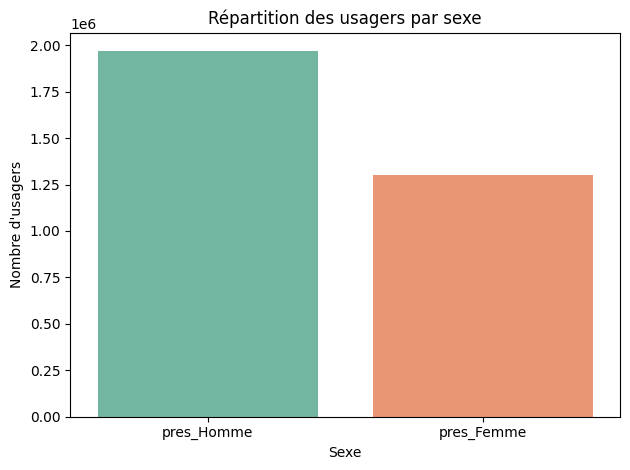

In [121]:
sexe_df = usagers_final[["pres_Homme", "pres_Femme"]].replace({2: 1}).sum()

plt.figure()
sns.barplot(x=sexe_df.index, y=sexe_df.values, palette="Set2")
plt.title("Répartition des usagers par sexe")
plt.ylabel("Nombre d'usagers")
plt.xlabel("Sexe")
plt.tight_layout()
plt.show()

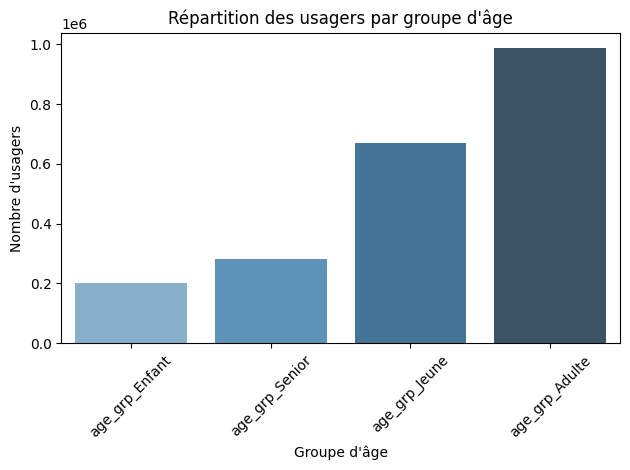

In [122]:
age_cols = ['age_grp_Enfant', 'age_grp_Adulte', 'age_grp_Jeune', 'age_grp_Senior']
df_age = usagers_final[age_cols].sum().sort_values()

plt.figure()
sns.barplot(x=df_age.index, y=df_age.values, palette="Blues_d")
plt.title("Répartition des usagers par groupe d'âge")
plt.ylabel("Nombre d'usagers")
plt.xlabel("Groupe d'âge")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

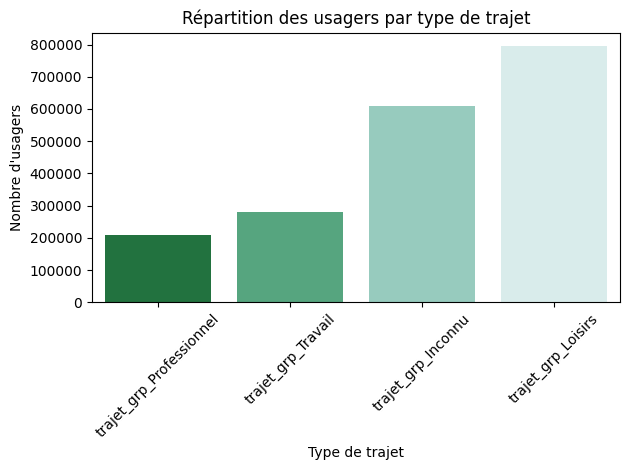

In [123]:
trajet_cols = ['trajet_grp_Inconnu', 'trajet_grp_Loisirs', 'trajet_grp_Professionnel', 'trajet_grp_Travail']
df_trajet = usagers_final[trajet_cols].sum().sort_values()

plt.figure()
sns.barplot(x=df_trajet.index, y=df_trajet.values, palette="BuGn_r")
plt.title("Répartition des usagers par type de trajet")
plt.ylabel("Nombre d'usagers")
plt.xlabel("Type de trajet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

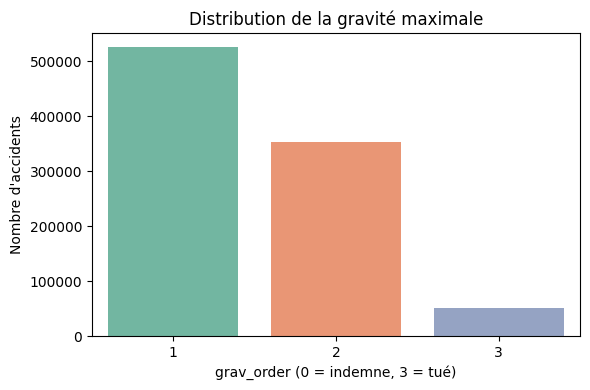

In [124]:
# Distribution de la variable cible
plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=df_merge_accident, palette="Set2")
plt.title("Distribution de la gravité maximale")
plt.xlabel("grav_order (0 = indemne, 3 = tué)")
plt.ylabel("Nombre d'accidents")
plt.tight_layout()
plt.show()

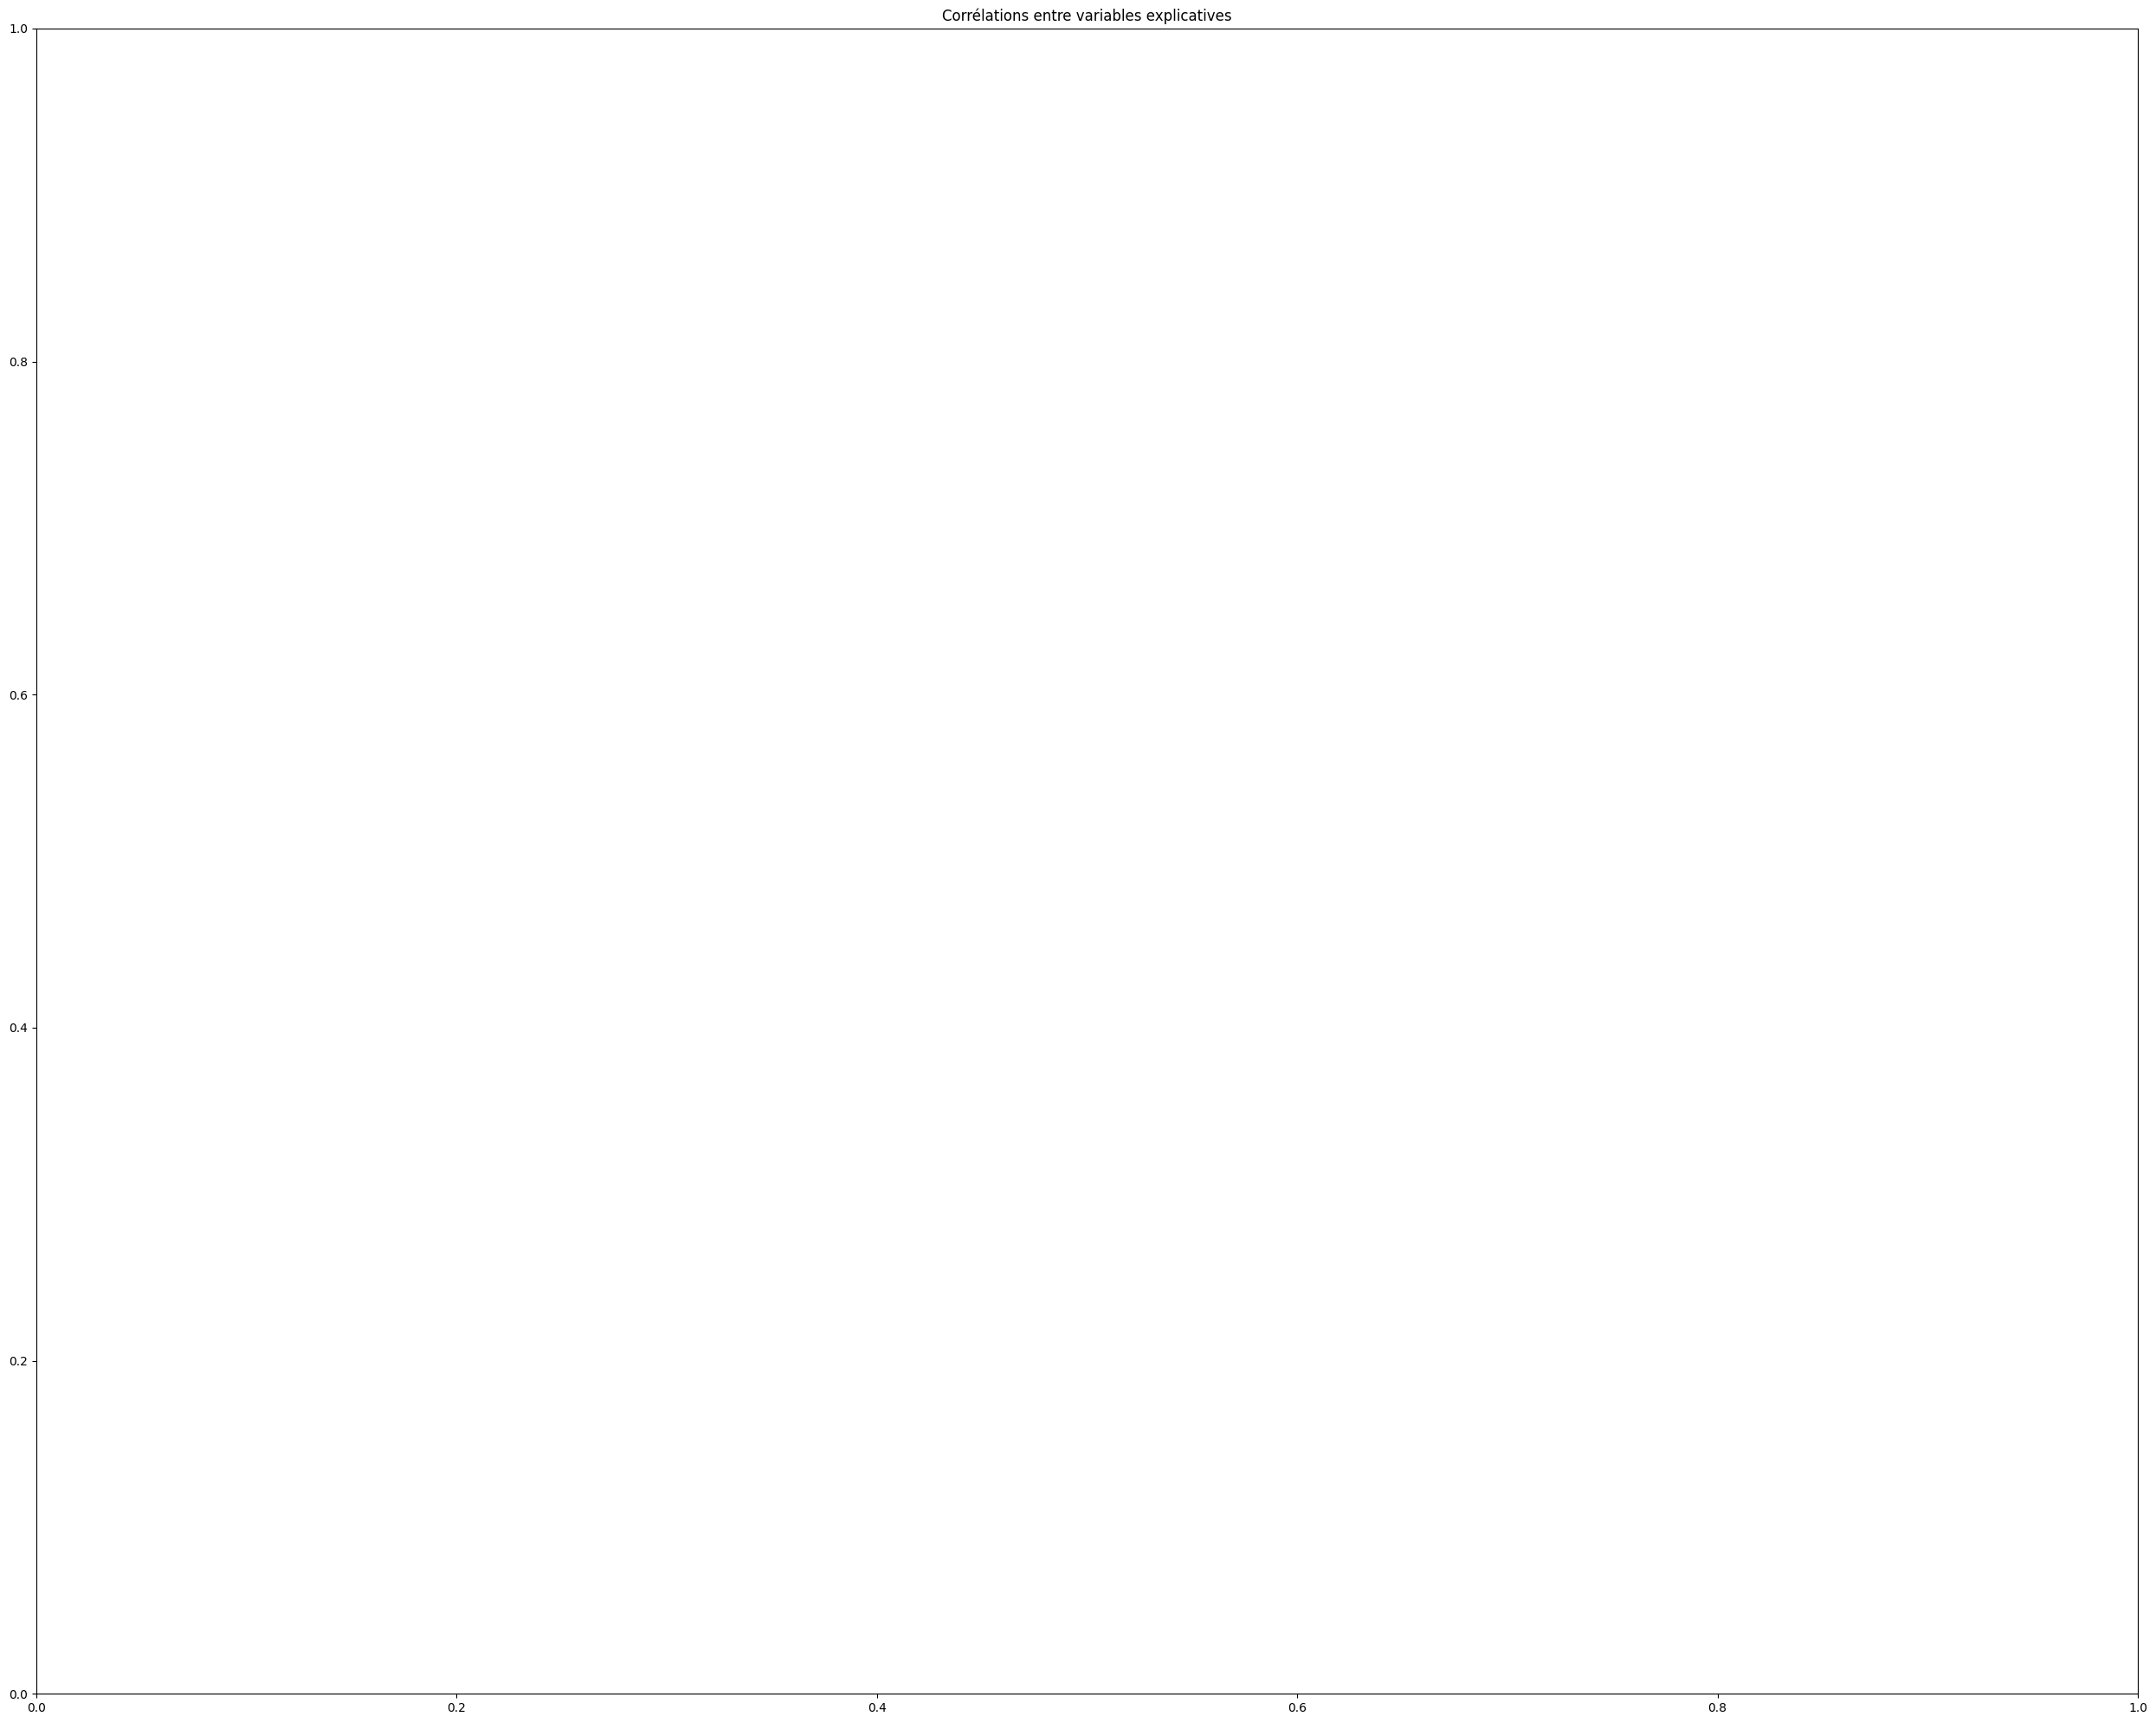

In [125]:
# Heatmap des correlations entre variables
plt.figure(figsize=(25, 20))
#sns.heatmap(df_merge_accident.corr(), annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Corrélations entre variables explicatives")
plt.tight_layout()
plt.show()

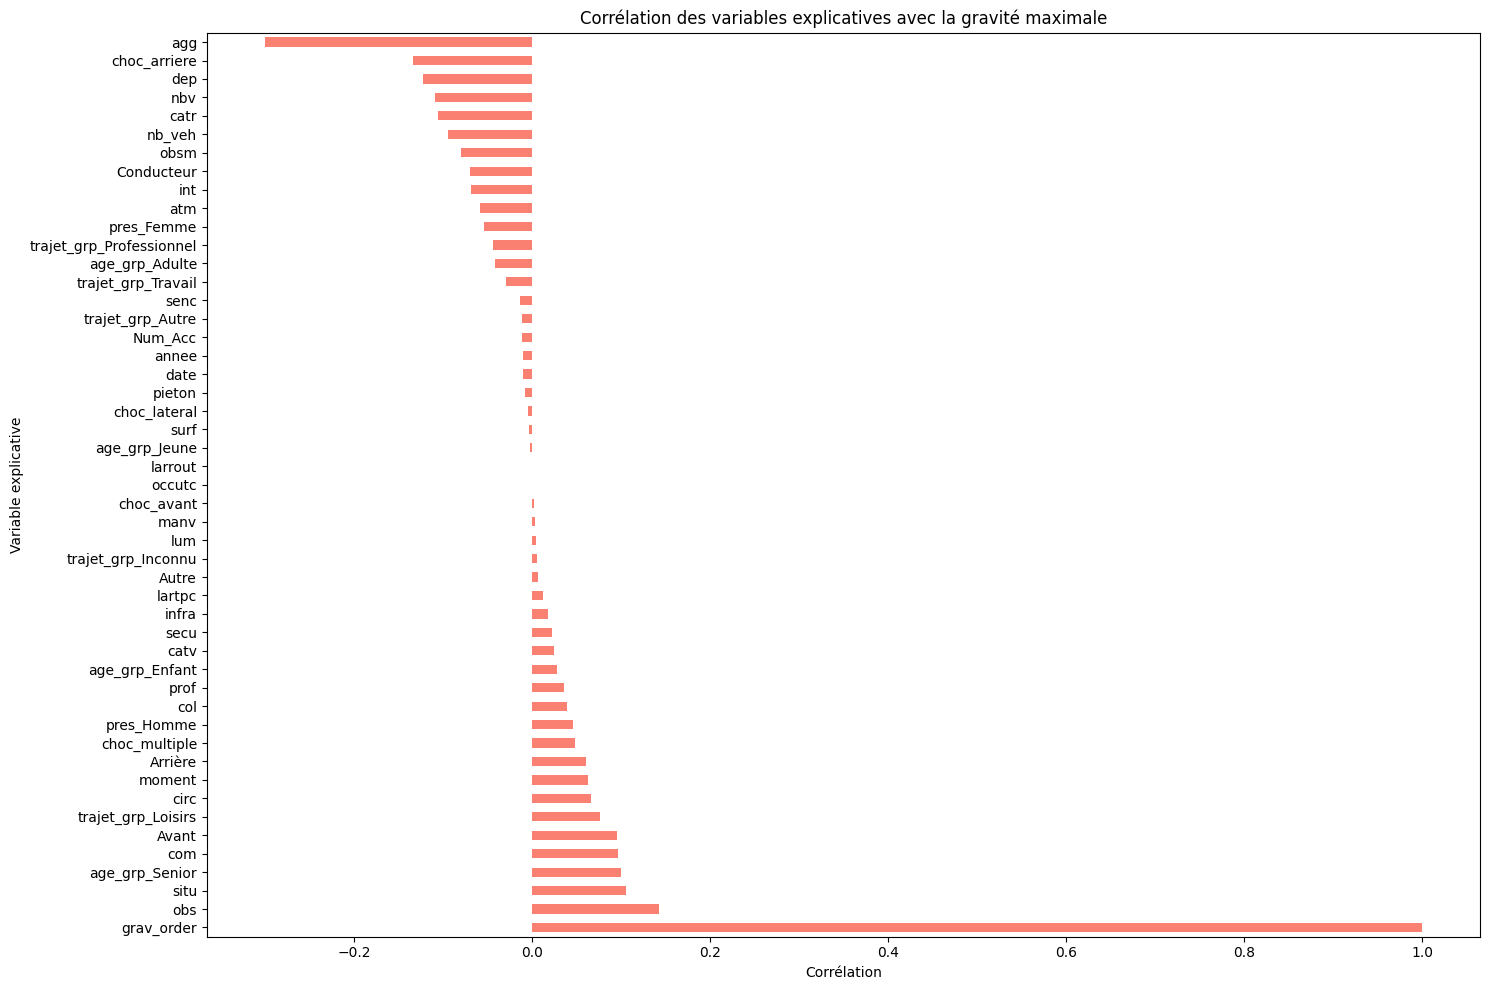

In [126]:
# Corrélation avec la variable cible
correlations = df_merge_accident.corrwith(df_merge_accident[target]).sort_values(ascending=False)
plt.figure(figsize=(15, 10))
correlations.plot(kind="barh", color="salmon")
plt.title("Corrélation des variables explicatives avec la gravité maximale")
plt.xlabel("Corrélation")
plt.ylabel("Variable explicative")
plt.tight_layout()
plt.show()

In [127]:
# Analyse de la relation des variables explicatives ave cla cible
colonnes_a_analyser = [
    "secu", "Conducteur", "lum", "agg", "int", "atm", "col", "moment", "senc", "obs", "obsm",
    "lartpc", "larrout", "surf", "infra", "situ", "choc_avant", "choc_arriere", "choc_lateral", "choc_multiple"
]

# Création de graphiques en batterie pour voir si certains sont intéressants à l'exploitation


''' CODE MIS EN COMMENTAIRE POUR NE PAS a LE RE-EXECUTER A CHAQUE FOIS QUE L'ON VEUT DEBUGGER - IL FAUDRA LE REACTIVER ENSUITE

for col in colonnes_a_analyser:
# Distribution de col vs grav
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_merge_accident, x=target, y=col, palette="pastel")
    plt.title(f"Distribution de {col} selon la gravité")
    plt.tight_layout()
    plt.show()

# Distribution de grav vs col
    prop = df_merge_accident.groupby(col)[target].value_counts(normalize=True).unstack().fillna(0)
    prop.plot(kind="bar", stacked=True, colormap="Reds", figsize=(6, 4))
    plt.title(f"Distribution de la gravité selon {col}")
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()

# Nombre d'accidents par type de choc
chocs = ["choc_avant", "choc_arriere", "choc_lateral", "choc_multiple"]
choc_counts = df_merge_accident[chocs].sum().sort_values()
choc_counts.plot(kind="barh", color="orange", figsize=(6, 4))
plt.title("Nombre d'accidents par type de choc (1+)")
plt.xlabel("Nombre d'accidents")
plt.tight_layout()
plt.show()

'''

' CODE MIS EN COMMENTAIRE POUR NE PAS a LE RE-EXECUTER A CHAQUE FOIS QUE L\'ON VEUT DEBUGGER - IL FAUDRA LE REACTIVER ENSUITE\n\nfor col in colonnes_a_analyser:\n# Distribution de col vs grav\n    plt.figure(figsize=(6, 4))\n    sns.boxplot(data=df_merge_accident, x=target, y=col, palette="pastel")\n    plt.title(f"Distribution de {col} selon la gravité")\n    plt.tight_layout()\n    plt.show()\n\n# Distribution de grav vs col\n    prop = df_merge_accident.groupby(col)[target].value_counts(normalize=True).unstack().fillna(0)\n    prop.plot(kind="bar", stacked=True, colormap="Reds", figsize=(6, 4))\n    plt.title(f"Distribution de la gravité selon {col}")\n    plt.ylabel("Proportion")\n    plt.tight_layout()\n    plt.show()\n\n# Nombre d\'accidents par type de choc\nchocs = ["choc_avant", "choc_arriere", "choc_lateral", "choc_multiple"]\nchoc_counts = df_merge_accident[chocs].sum().sort_values()\nchoc_counts.plot(kind="barh", color="orange", figsize=(6, 4))\nplt.title("Nombre d\'acciden

### Corrections bruit

In [128]:
df_merge_accident.isna().sum()

Num_Acc                       0
lum                           0
agg                           0
int                           0
atm                           0
col                           0
com                           0
dep                           0
date                          0
moment                        0
senc                        239
catv                        239
occutc                      239
obs                         239
obsm                        239
manv                        239
annee                       239
nb_veh                      239
choc_avant                  239
choc_arriere                239
choc_lateral                239
choc_multiple               239
grav_order                    0
secu                          0
pieton                        0
Conducteur                    0
Autre                         0
Arrière                       0
Avant                         0
pres_Homme                    0
pres_Femme                    0
age_grp_

In [129]:
df_merge_accident = df_merge_accident.dropna(axis=0)
df_merge_accident.isna().sum()

Num_Acc                     0
lum                         0
agg                         0
int                         0
atm                         0
col                         0
com                         0
dep                         0
date                        0
moment                      0
senc                        0
catv                        0
occutc                      0
obs                         0
obsm                        0
manv                        0
annee                       0
nb_veh                      0
choc_avant                  0
choc_arriere                0
choc_lateral                0
choc_multiple               0
grav_order                  0
secu                        0
pieton                      0
Conducteur                  0
Autre                       0
Arrière                     0
Avant                       0
pres_Homme                  0
pres_Femme                  0
age_grp_Enfant              0
age_grp_Adulte              0
age_grp_Je

In [130]:
df_merge_usager = df_merge_usager.dropna(axis=0)
df_merge_usager.isna().sum()

Num_Acc                     0
grav                        0
secu                        0
pieton                      0
Arrière                     0
Autre                       0
Avant                       0
Conducteur                  0
pres_Homme                  0
pres_Femme                  0
age_grp_Adulte              0
age_grp_Enfant              0
age_grp_Jeune               0
age_grp_Senior              0
trajet_grp_Autre            0
trajet_grp_Inconnu          0
trajet_grp_Loisirs          0
trajet_grp_Professionnel    0
trajet_grp_Travail          0
grav_order                  0
lum                         0
agg                         0
int                         0
atm                         0
col                         0
com                         0
dep                         0
date                        0
moment                      0
senc                        0
catv                        0
occutc                      0
obs                         0
obsm      

## <font color="blue">__Final__</font>

__Dataframes finaux__
- 1/ df_merge_usager => approche par accident (vision synthétique / mais avec des aggrégations)
  => prédire la gravité max d'un accident (grav_order)
- 2/ df_merge_usager => approche par usager (plus fin) => prédire la gravité pour chaque usager (grav)

In [131]:
print(df_merge_accident.info())
df_merge_accident.describe(include="all")
#df_merge_accident.isna().sum()
#df_merge_accident.catr.unique()
# Il reste des NaN en raison des filtres du début (sur les dep)

<class 'pandas.core.frame.DataFrame'>
Index: 928877 entries, 0 to 929116
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Num_Acc                   928877 non-null  object        
 1   lum                       928877 non-null  int64         
 2   agg                       928877 non-null  int64         
 3   int                       928877 non-null  int64         
 4   atm                       928877 non-null  object        
 5   col                       928877 non-null  float64       
 6   com                       928877 non-null  object        
 7   dep                       928877 non-null  object        
 8   date                      928877 non-null  datetime64[ns]
 9   moment                    928877 non-null  object        
 10  senc                      928877 non-null  float64       
 11  catv                      928877 non-null  float64       
 12  occutc 

,Num_Acc,lum,agg,int,atm,col,com,dep,date,moment,...,trajet_grp_Travail,catr,circ,nbv,prof,lartpc,larrout,surf,infra,situ
count,928877,928877.000000,928877.000000,928877.000000,928877,928877.000000,928877,928877,928877,928877,...,928877.000000,928877.000000,928877.000000,928877.000000,928877.000000,928877.000000,928877.000000,928877,928877.000000,928877.000000
unique,928877,NaN,NaN,NaN,3,NaN,1023,105,NaN,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
top,201800055766,NaN,NaN,NaN,1,NaN,055,750,NaN,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
freq,1,NaN,NaN,NaN,877787,NaN,36349,99015,NaN,357975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,880837,NaN,NaN
mean,NaN,1.905878,1.682901,1.727900,NaN,4.191315,NaN,NaN,2011-06-11 03:25:47.348465152,NaN,...,0.295103,3.413056,1.853498,2.068233,1.140112,4.982466,54.926900,NaN,0.437166,1.182421
min,NaN,1.000000,1.000000,0.000000,NaN,1.000000,NaN,NaN,2005-01-01 00:00:00,NaN,...,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-81.000000,NaN,-1.000000,-1.000000
25%,NaN,1.000000,1.000000,1.000000,NaN,3.000000,NaN,NaN,2007-10-30 00:00:00,NaN,...,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,NaN,0.000000,1.000000
50%,NaN,1.000000,2.000000,1.000000,NaN,3.000000,NaN,NaN,2011-01-27 00:00:00,NaN,...,0.000000,4.000000,2.000000,2.000000,1.000000,0.000000,59.000000,NaN,0.000000,1.000000
75%,NaN,3.000000,2.000000,2.000000,NaN,6.000000,NaN,NaN,2014-12-06 00:00:00,NaN,...,0.000000,4.000000,2.000000,2.000000,1.000000,0.000000,79.000000,NaN,0.000000,1.000000
max,NaN,5.000000,2.000000,9.000000,NaN,7.000000,NaN,NaN,2018-12-31 00:00:00,NaN,...,51.000000,9.000000,4.000000,99.000000,4.000000,960.000000,999.000000,NaN,7.000000,5.000000


In [132]:
df_merge_usager.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2073580 entries, 0 to 2137496
Data columns (total 50 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   Num_Acc                   object        
 1   grav                      int64         
 2   secu                      Int64         
 3   pieton                    int64         
 4   Arrière                   int64         
 5   Autre                     int64         
 6   Avant                     int64         
 7   Conducteur                int64         
 8   pres_Homme                int64         
 9   pres_Femme                int64         
 10  age_grp_Adulte            bool          
 11  age_grp_Enfant            bool          
 12  age_grp_Jeune             bool          
 13  age_grp_Senior            bool          
 14  trajet_grp_Autre          bool          
 15  trajet_grp_Inconnu        bool          
 16  trajet_grp_Loisirs        bool          
 17  trajet_grp_Pr

In [133]:
df_merge_usager.describe()
#df_merge_usager.isna().sum()

# Il reste des NaN en raison des filtres du début (sur les dep)

,grav,secu,pieton,Arrière,Autre,Avant,Conducteur,pres_Homme,pres_Femme,grav_order,...,choc_lateral,choc_multiple,catr,circ,nbv,prof,lartpc,larrout,infra,situ
count,2.073580e+06,2073580.0,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,...,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06,2.073580e+06
mean,2.511614e+00,0.776795,8.296232e-02,5.640294e-02,9.254285e-02,1.051780e-01,7.458762e-01,1.489249e+00,8.456597e-01,8.510885e-01,...,2.140337e-01,2.538991e-02,3.348247e+00,1.878161e+00,2.109240e+00,1.142297e+00,5.238656e+00,5.672527e+01,4.569435e-01,1.140135e+00
min,1.000000e+00,-1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-8.100000e+01,-1.000000e+00,-1.000000e+00
25%,1.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,3.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,3.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,6.000000e+01,0.000000e+00,1.000000e+00
75%,4.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,8.000000e+01,0.000000e+00,1.000000e+00
max,4.000000e+00,9.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,...,1.000000e+00,1.000000e+00,9.000000e+00,4.000000e+00,9.900000e+01,4.000000e+00,9.600000e+02,9.990000e+02,7.000000e+00,5.000000e+00
std,1.334975e+00,1.129285,2.758253e-01,2.306982e-01,2.897908e-01,3.067827e-01,4.353676e-01,6.433067e-01,7.752274e-01,8.370662e-01,...,4.101504e-01,1.573063e-01,1.214830e+00,7.317190e-01,1.541249e+00,6.197656e-01,2.278099e+01,6.556819e+01,1.387496e+00,7.204245e-01


## <font color="blue">__Retraitements nécessaires pour la modélisation__</font>


### __Encodage/..__

In [134]:
# Retraitements nécessaires pour la modélisation

# date
df_merge_accident["annee"] = df_merge_accident["date"].dt.year
df_merge_accident["mois"] = df_merge_accident["date"].dt.month
df_merge_accident["jour"] = df_merge_accident["date"].dt.day
df_merge_accident["jour_semaine"] = df_merge_accident["date"].dt.dayofweek
df_merge_accident["is_we"] = df_merge_accident["jour_semaine"].isin([5, 6]).astype(int)

df_merge_usager["annee"] = df_merge_usager["date"].dt.year
df_merge_usager["mois"] = df_merge_usager["date"].dt.month
df_merge_usager["jour"] = df_merge_usager["date"].dt.day
df_merge_usager["jour_semaine"] = df_merge_usager["date"].dt.dayofweek
df_merge_usager["is_we"] = df_merge_usager["jour_semaine"].isin([5, 6]).astype(int)


# Encodage des variables catégorielles

from sklearn.preprocessing import LabelEncoder

# atm et surf
#- accident
le_acc_atm = LabelEncoder()
df_merge_accident["atm_enc"] = le_acc_atm.fit_transform(df_merge_accident["atm"])

le_acc_surf = LabelEncoder()
df_merge_accident["surf_enc"] = le_acc_surf.fit_transform(df_merge_accident["surf"])

#- usager
le_usag_atm = LabelEncoder()
df_merge_usager["atm_enc"] = le_usag_atm.fit_transform(df_merge_usager["atm"])

le_usag_surf = LabelEncoder()
df_merge_usager["surf_enc"] = le_usag_surf.fit_transform(df_merge_usager["surf"])


In [135]:
# on supprime les colonnes inutiles
df_merge_accident = df_merge_accident.drop(columns=["date", "Num_Acc", "com", "dep", "atm", "surf"], axis=1)
df_merge_usager = df_merge_usager.drop(columns=["date", "Num_Acc", "com", "dep", "atm", "surf"], axis=1)

In [136]:
print(df_merge_accident.info())
print(df_merge_usager.info())

<class 'pandas.core.frame.DataFrame'>
Index: 928877 entries, 0 to 929116
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   lum                       928877 non-null  int64  
 1   agg                       928877 non-null  int64  
 2   int                       928877 non-null  int64  
 3   col                       928877 non-null  float64
 4   moment                    928877 non-null  object 
 5   senc                      928877 non-null  float64
 6   catv                      928877 non-null  float64
 7   occutc                    928877 non-null  float64
 8   obs                       928877 non-null  float64
 9   obsm                      928877 non-null  float64
 10  manv                      928877 non-null  float64
 11  annee                     928877 non-null  int32  
 12  nb_veh                    928877 non-null  float64
 13  choc_avant                928877 non-null  float6

### __Separation features / target__

In [137]:
X_acc = df_merge_accident.drop("grav_order", axis=1)
y_acc = df_merge_accident["grav_order"]

X_usag = df_merge_usager.drop(columns=["grav", "grav_order"], axis=1)
y_usag = df_merge_usager["grav"]

### __Decoupage train/test__

In [138]:
from sklearn.model_selection import train_test_split

# Stratify => car classes déséquilibréés
X_acc_train, X_acc_test, y_acc_train, y_acc_test = train_test_split(X_acc, y_acc, test_size=0.2, random_state=42, stratify=y_acc)
X_usag_train, X_usag_test, y_usag_train, y_usag_test = train_test_split(X_usag, y_usag, test_size=0.2, random_state=42, stratify=y_usag)

### __Standardisation / Normalisation__

from sklearn.preprocessing import StandardScaler

# Par accident
scaler_acc = StandardScaler()
X_acc_train_scaled = pd.DataFrame(scaler_acc.fit_transform(X_acc_train), columns=X_acc_train.columns, index=X_acc_train.index)
X_acc_test_scaled = pd.DataFrame(scaler_acc.transform(X_acc_test), columns=X_acc_test.columns, index=X_acc_test.index)

# Par usager
scaler_usag = StandardScaler()
X_usag_train_scaled = pd.DataFrame(scaler_usag.fit_transform(X_usag_train), columns=X_usag_train.columns, index=X_usag_train.index)
X_usag_test_scaled = pd.DataFrame(scaler_usag.transform(X_usag_test), columns=X_usag_test.columns, index=X_usag_test.index)

In [139]:
from sklearn.preprocessing import StandardScaler

# AVANT le scaling (sauvegarder les index si tu en auras besoin plus tard)
train_index_acc = X_acc_train.index
test_index_acc  = X_acc_test.index

# Par accident
scaler_acc = StandardScaler()
X_acc_train_scaled = scaler_acc.fit_transform(X_acc_train)
X_acc_test_scaled = scaler_acc.transform(X_acc_test)

# Par usager
scaler_usag = StandardScaler()
X_usag_train_scaled = scaler_usag.fit_transform(X_usag_train)
X_usag_test_scaled = scaler_usag.transform(X_usag_test)

### __Reduction de dimension__

from sklearn.feature_selection import SelectKBest, f_classif

# Par accident
selector_acc = SelectKBest(score_func=f_classif, k=20)  # garde les 20 meilleures features
X_acc_train_selected = selector_acc.fit_transform(X_acc_train_scaled, y_acc_train)
X_acc_test_selected = selector_acc.transform(X_acc_test_scaled)

# Par usager
selector_usag = SelectKBest(score_func=f_classif, k=20)  # garde les 20 meilleures features
X_usag_train_selected = selector_usag.fit_transform(X_usag_train_scaled, y_usag_train)
X_usag_test_selected = selector_usag.transform(X_usag_test_scaled)


# colonnes retenues
selected_acc_cols = X_acc_train_scaled.columns[selector_acc.get_support()]
selected_usag_cols = X_usag_train_scaled.columns[selector_usag.get_support()]
print("Colonnes sélectionnées accidents:", list(selected_acc_cols))
print("Colonnes sélectionnées usager:", list(selected_usag_cols))

X_acc_train_selected = pd.DataFrame(X_acc_train_selected, columns=selected_acc_cols, index=X_acc_train_scaled.index)
X_acc_test_selected = pd.DataFrame(X_acc_test_selected, columns=selected_acc_cols, index=X_acc_test_scaled.index)

X_usag_train_selected = pd.DataFrame(X_usag_train_selected, columns=selected_usag_cols, index=X_usag_train_scaled.index)
X_usag_test_selected = pd.DataFrame(X_usag_test_selected, columns=selected_usag_cols, index=X_usag_test_scaled.index)



In [140]:
from sklearn.feature_selection import SelectKBest, f_classif

# Par accident
selector_acc = SelectKBest(score_func=f_classif, k=10)  # garde les 20 meilleures features
X_acc_train_selected = selector_acc.fit_transform(X_acc_train_scaled, y_acc_train)
X_acc_test_selected = selector_acc.transform(X_acc_test_scaled)

# Par usager
selector_usag = SelectKBest(score_func=f_classif, k=10)  # garde les 20 meilleures features
X_usag_train_selected = selector_usag.fit_transform(X_usag_train_scaled, y_usag_train)
X_usag_test_selected = selector_usag.transform(X_usag_test_scaled)


# colonnes retenues
selected_acc_cols = X_acc_train.columns[selector_acc.get_support()]
selected_usag_cols = X_usag_train.columns[selector_usag.get_support()]
print("Colonnes sélectionnées accidents:", list(selected_acc_cols))
print("Colonnes sélectionnées usager:", list(selected_usag_cols))

'''X_acc_train_selected = pd.DataFrame(X_acc_train_selected, columns=selected_acc_cols, index=X_acc_train_scaled.index)
X_acc_test_selected = pd.DataFrame(X_acc_test_selected, columns=selected_acc_cols, index=X_acc_test_scaled.index)

X_usag_train_selected = pd.DataFrame(X_usag_train_selected, columns=selected_usag_cols, index=X_usag_train_scaled.index)
X_usag_test_selected = pd.DataFrame(X_usag_test_selected, columns=selected_usag_cols, index=X_usag_test_scaled.index)
'''


Colonnes sélectionnées accidents: ['agg', 'obs', 'obsm', 'nb_veh', 'choc_arriere', 'Avant', 'age_grp_Senior', 'catr', 'nbv', 'situ']
Colonnes sélectionnées usager: ['pieton', 'Autre', 'Conducteur', 'age_grp_Enfant', 'trajet_grp_Professionnel', 'agg', 'obs', 'obsm', 'nb_veh', 'choc_arriere']


'X_acc_train_selected = pd.DataFrame(X_acc_train_selected, columns=selected_acc_cols, index=X_acc_train_scaled.index)\nX_acc_test_selected = pd.DataFrame(X_acc_test_selected, columns=selected_acc_cols, index=X_acc_test_scaled.index)\n\nX_usag_train_selected = pd.DataFrame(X_usag_train_selected, columns=selected_usag_cols, index=X_usag_train_scaled.index)\nX_usag_test_selected = pd.DataFrame(X_usag_test_selected, columns=selected_usag_cols, index=X_usag_test_scaled.index)\n'

## <font color="blue">__Modélisation__</font>

In [141]:
from sklearn.metrics import classification_report, confusion_matrix


In [144]:
'''from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Exemple avec régression logistique

# - Accident
model_LR_acc = LogisticRegression(max_iter=500)
model_LR_acc.fit(X_acc_train_selected, y_acc_train)

y_acc_pred = model_LR_acc.predict(X_acc_test_selected)

print("########################\n# Modèle Régression Logistique: #\n ########################\n")
print("Acc: Matrice de confusion\n", confusion_matrix(y_acc_test, y_acc_pred))
print("Acc: Classification_report\n", classification_report(y_acc_test, y_acc_pred))


# - Usager
model_LR_usag = LogisticRegression(max_iter=500)
model_LR_usag.fit(X_usag_train_selected, y_usag_train)

y_usag_LR_pred = model_LR_usag.predict(X_usag_test_selected)

print("\n ------------ \n")
print("Usag: Matrice de confusion\n", confusion_matrix(y_usag_test, y_usag_LR_pred))
print("Usag: Classification_report\n", classification_report(y_usag_test, y_usag_LR_pred))


###########
# Exemple avec RandomForest

# - Accident
model_RF_acc = RandomForestClassifier(n_estimators=100, max_depth=16, min_samples_leaf=10, n_jobs=4, random_state=42)
model_RF_acc.fit(X_acc_train_selected, y_acc_train)

y_acc_RF_pred = model_RF_acc.predict(X_acc_test_selected)

print("\n\n ###################\n#  Modèle Random Forest:  #\n ###################\n")
print("Acc: Matrice de confusion\n", confusion_matrix(y_acc_test, y_acc_RF_pred))
print("Acc: Classification_report\n", classification_report(y_acc_test, y_acc_RF_pred))


# - Usager
model_RF_usag = RandomForestClassifier(n_estimators=200, max_depth=16, min_samples_leaf=10, n_jobs=-1, random_state=42)
model_RF_usag.fit(X_usag_train_selected, y_usag_train)

y_usag_RF_pred = model_RF_usag.predict(X_usag_test_selected)

print("\n ------------  \n")
print("Usag: Matrice de confusion\n", confusion_matrix(y_usag_test, y_usag_RF_pred))
print("Usag: Classification_report\n", classification_report(y_usag_test, y_usag_RF_pred))'''

'from sklearn.linear_model import LogisticRegression\nfrom sklearn.ensemble import RandomForestClassifier\n\n# Exemple avec régression logistique\n\n# - Accident\nmodel_LR_acc = LogisticRegression(max_iter=500)\nmodel_LR_acc.fit(X_acc_train_selected, y_acc_train)\n\ny_acc_pred = model_LR_acc.predict(X_acc_test_selected)\n\nprint("########################\n# Modèle Régression Logistique: #\n ########################\n")\nprint("Acc: Matrice de confusion\n", confusion_matrix(y_acc_test, y_acc_pred))\nprint("Acc: Classification_report\n", classification_report(y_acc_test, y_acc_pred))\n\n\n# - Usager\nmodel_LR_usag = LogisticRegression(max_iter=500)\nmodel_LR_usag.fit(X_usag_train_selected, y_usag_train)\n\ny_usag_LR_pred = model_LR_usag.predict(X_usag_test_selected)\n\nprint("\n ------------ \n")\nprint("Usag: Matrice de confusion\n", confusion_matrix(y_usag_test, y_usag_LR_pred))\nprint("Usag: Classification_report\n", classification_report(y_usag_test, y_usag_LR_pred))\n\n\n###########

In [145]:
# Analyse des résultats
print("==> Régression logistique: \n-------------------------")
print("Analyse accident: \n\
    > La classe 3 (sévère) est quasi-toujours prédite en 1 ou 2 (probablement lié au biais du déséquilibre?)\n \
    > La classe 2 est plus prédite en 1\n \
    > La classe 1 est la mieux prédite \
    ")
print("Analyse usager: \n\
    > La classe 2 n'est jamais prédite ! (precision=recall=0)")

print("\n\n ==> Random Forest: \n-------------------")
print("Analyse accident (résultats semblables à RL): \n\
    > (pareil) La classe 3 (sévère) est quasi-toujours prédite en 1 ou 2 (probablement lié au biais du déséquilibre?)\n \
    > La classe 2 est mal prédite (autant en 2 qu'en 1\n \
    ")
print("Analyse usager: \n\
    > (pareil) La classe 2 n'est jamais prédite ! (recall~=0)")

==> Régression logistique: 
-------------------------
Analyse accident: 
    > La classe 3 (sévère) est quasi-toujours prédite en 1 ou 2 (probablement lié au biais du déséquilibre?)
     > La classe 2 est plus prédite en 1
     > La classe 1 est la mieux prédite     
Analyse usager: 
    > La classe 2 n'est jamais prédite ! (precision=recall=0)


 ==> Random Forest: 
-------------------
Analyse accident (résultats semblables à RL): 
    > (pareil) La classe 3 (sévère) est quasi-toujours prédite en 1 ou 2 (probablement lié au biais du déséquilibre?)
     > La classe 2 est mal prédite (autant en 2 qu'en 1
     
Analyse usager: 
    > (pareil) La classe 2 n'est jamais prédite ! (recall~=0)


In [146]:
print("> Tenter un under-sampling des classes majoritaire?")

> Tenter un under-sampling des classes majoritaire?


In [147]:
'''from imblearn.ensemble import BalancedRandomForestClassifier
# sous-échantillonne les classes majoritaires par RF

BRF_acc = BalancedRandomForestClassifier(
    n_estimators=100,
    max_depth=16,
    min_samples_leaf=10,
    max_features="sqrt",
    sampling_strategy="not majority",
    replacement=False,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced"
)
BRF_acc.fit(X_acc_train_selected, y_acc_train)

y_BRF_acc = BRF_acc.predict(X_acc_test_selected)

print("ACC (Balanced RF):")
print(confusion_matrix(y_acc_test, y_BRF_acc))
print(classification_report(y_acc_test, y_BRF_acc, digits=3))
'''


'from imblearn.ensemble import BalancedRandomForestClassifier\n# sous-échantillonne les classes majoritaires par RF\n\nBRF_acc = BalancedRandomForestClassifier(\n    n_estimators=100,\n    max_depth=16,\n    min_samples_leaf=10,\n    max_features="sqrt",\n    sampling_strategy="not majority",\n    replacement=False,\n    n_jobs=-1,\n    random_state=42,\n    class_weight="balanced"\n)\nBRF_acc.fit(X_acc_train_selected, y_acc_train)\n\ny_BRF_acc = BRF_acc.predict(X_acc_test_selected)\n\nprint("ACC (Balanced RF):")\nprint(confusion_matrix(y_acc_test, y_BRF_acc))\nprint(classification_report(y_acc_test, y_BRF_acc, digits=3))\n'

In [148]:
# Analyse des résultats
print("==> Random Forest (avec un sous-échantillonnage des classes majoritaires): \n-------------------")
print("Analyse accident : \n\
    > Pas beaucoup mieux (la classe 2 n'est pas du tout prédite)! :(     ")

==> Random Forest (avec un sous-échantillonnage des classes majoritaires): 
-------------------
Analyse accident : 
    > Pas beaucoup mieux (la classe 2 n'est pas du tout prédite)! :(     


In [149]:
'''print(y_acc_train.value_counts(normalize=True))
print(y_acc_test.value_counts(normalize=True))'''

'print(y_acc_train.value_counts(normalize=True))\nprint(y_acc_test.value_counts(normalize=True))'

In [150]:
'''from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

non_numeric_cols = X_acc_train.select_dtypes(include=['object']).columns
print("Colonnes non numériques dans X_acc_train :", non_numeric_cols)
X_acc_train_smote = X_acc_train.drop(columns=non_numeric_cols).astype('float64')
X_acc_test_smote = X_acc_test.drop(columns=non_numeric_cols).astype('float64')

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_acc_train_smote, y_acc_train)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_res, y_res)
y_pred = clf.predict(X_acc_test_smote)

#X_acc_train_smote = X_acc_train_smote.astype('float64')
#X_acc_test_smote = X_acc_test_smote.astype('float64')

#smote_rf_pipeline.fit(X_acc_train_smote, y_acc_train)
#y_pred = smote_rf_pipeline.predict(X_acc_test_smote)'''

'from imblearn.pipeline import Pipeline\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.ensemble import RandomForestClassifier\n\nnon_numeric_cols = X_acc_train.select_dtypes(include=[\'object\']).columns\nprint("Colonnes non numériques dans X_acc_train :", non_numeric_cols)\nX_acc_train_smote = X_acc_train.drop(columns=non_numeric_cols).astype(\'float64\')\nX_acc_test_smote = X_acc_test.drop(columns=non_numeric_cols).astype(\'float64\')\n\nsm = SMOTE(random_state=42)\nX_res, y_res = sm.fit_resample(X_acc_train_smote, y_acc_train)\n\nclf = RandomForestClassifier(n_estimators=100, random_state=42)\nclf.fit(X_res, y_res)\ny_pred = clf.predict(X_acc_test_smote)\n\n#X_acc_train_smote = X_acc_train_smote.astype(\'float64\')\n#X_acc_test_smote = X_acc_test_smote.astype(\'float64\')\n\n#smote_rf_pipeline.fit(X_acc_train_smote, y_acc_train)\n#y_pred = smote_rf_pipeline.predict(X_acc_test_smote)'

In [153]:
#print(confusion_matrix(y_acc_test, y_pred))

## Next steps

In [154]:
'''Nettoyage plus robuste en amont (supprimer les dernières colonnes non numériques)
Réduire les colonnes très corrélées ou peu utiles (PCA)?
Tester des modèles plus puissants => XGBoost / DecisionTree / ADABoost
CV
Regroupement de classes'''

'Nettoyage plus robuste en amont (supprimer les dernières colonnes non numériques)\nRéduire les colonnes très corrélées ou peu utiles (PCA)?\nTester des modèles plus puissants => XGBoost / DecisionTree / ADABoost\nCV\nRegroupement de classes'

In [155]:
'''import xgboost
from xgboost import XGBClassifier

# Initialisation du modèle XGBoost
xgb_model = XGBClassifier(
    objective='multi:softmax',      # Pour classification multi-classes
    num_class=4,                    # Adapte à ton nombre de classes (grav_order 1,2,3,4)
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1                       # Utilise tous les cœurs dispo
)

# Entraînement
xgb_model.fit(X_acc_train_selected, y_acc_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_acc_test_selected)

# Évaluation
print("Confusion matrix:\n", confusion_matrix(y_acc_test, y_pred_xgb))
print("\nClassification report:\n", classification_report(y_acc_test, y_pred_xgb))'''

'import xgboost\nfrom xgboost import XGBClassifier\n\n# Initialisation du modèle XGBoost\nxgb_model = XGBClassifier(\n    objective=\'multi:softmax\',      # Pour classification multi-classes\n    num_class=4,                    # Adapte à ton nombre de classes (grav_order 1,2,3,4)\n    eval_metric=\'mlogloss\',\n    use_label_encoder=False,\n    n_estimators=50,\n    max_depth=6,\n    learning_rate=0.1,\n    random_state=42,\n    n_jobs=-1                       # Utilise tous les cœurs dispo\n)\n\n# Entraînement\nxgb_model.fit(X_acc_train_selected, y_acc_train)\n\n# Prédictions\ny_pred_xgb = xgb_model.predict(X_acc_test_selected)\n\n# Évaluation\nprint("Confusion matrix:\n", confusion_matrix(y_acc_test, y_pred_xgb))\nprint("\nClassification report:\n", classification_report(y_acc_test, y_pred_xgb))'

[texte du lien](https://)__Aide__

In [156]:
import numpy as np, gc, multiprocessing as mp
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

def as_float32(X):
    X_np = X.values if hasattr(X, "values") else X
    return X_np.astype(np.float32, copy=False)

def class_weights_dict(y):
    cls = np.unique(y)
    w = compute_class_weight('balanced', classes=cls, y=y)
    return dict(zip(cls, w)), cls

def sensible_n_jobs():
    cpu = max(1, mp.cpu_count() - 1)
    return int(min(8, max(1, int(cpu * 0.75))))

def quick_report(y_true, y_pred, label=""):
    print(f"\n== {label} ==")
    print("Balanced Accuracy:", round(balanced_accuracy_score(y_true, y_pred), 4))
    print("Macro F1:", round(f1_score(y_true, y_pred, average='macro'), 4))
    print(classification_report(y_true, y_pred, digits=3))

In [157]:
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score
import gc

# ---------- 1) Encodage compact + float32 ----------
# (si tu as encore des colonnes objet/catégorielles)
for col in X_acc_train.select_dtypes(include=['object','category']).columns:
    X_acc_train[col] = X_acc_train[col].astype('category').cat.codes.astype('int16')
    X_acc_test[col]  = X_acc_test[col].astype('category').cat.codes.astype('int16')

Xtr = X_acc_train.astype(np.float32, copy=False)
Xte = X_acc_test.astype(np.float32, copy=False)

# ---------- 2) Stratégies SMOTE / RUS adaptées au multi-classe ----------
from math import floor

def make_smote_strategy(y, ratio=0.5):
    """
    Porte chaque classe minoritaire à ratio * (taille de la classe majoritaire).
    Ex: ratio=0.5 => chaque minoritaire atteint 50% de la majoritaire.
    """
    cnt = Counter(y)
    maj = max(cnt.values())
    target = int(floor(maj * ratio))
    # Ne sur-échantillonne que celles < target
    strat = {cls: target for cls, n in cnt.items() if n < target}
    return strat

def make_rus_strategy(y, alpha=0.9):
    """
    Baisse les classes trop grosses à alpha * (taille majoritaire).
    (Sous-échantillonnage doux pour limiter la RAM)
    """
    cnt = Counter(y)
    maj_cap = int(floor(max(cnt.values()) * alpha))
    strat = {cls: maj_cap for cls, n in cnt.items() if n > maj_cap}
    return strat

smote_strategy = make_smote_strategy(y_acc_train, ratio=0.5)   # <= clé: dict, pas float
rus_strategy   = make_rus_strategy(y_acc_train, alpha=0.9)

# SMOTE doit avoir assez de voisins: k_neighbors <= (effectif min - 1)
min_class_n = min(Counter(y_acc_train).values())
k_smote = 3 if min_class_n > 3 else 1

smote = SMOTE(sampling_strategy=(smote_strategy if smote_strategy else 'not majority'),
              k_neighbors=k_smote, random_state=42)

steps = [("smote", smote)]
if rus_strategy:  # ajoute RUS seulement si utile
    steps.append(("rus", RandomUnderSampler(sampling_strategy=rus_strategy, random_state=42)))

# Modèle léger et robuste (bien pour gros volumes)
clf = HistGradientBoostingClassifier(
    max_iter=600, learning_rate=0.08, l2_regularization=1.0,
    early_stopping=True, validation_fraction=0.1, random_state=42
)

steps.append(("clf", clf))
pipe_smote_hgb = ImbPipeline(steps=steps)

# ---------- 3) Fit + Eval ----------
pipe_smote_hgb.fit(Xtr, y_acc_train)
y_pred = pipe_smote_hgb.predict(Xte)

print("Balanced Acc:", round(balanced_accuracy_score(y_acc_test, y_pred), 4))
print("Macro F1    :", round(f1_score(y_acc_test, y_pred, average='macro'), 4))
print(classification_report(y_acc_test, y_pred, digits=3))

gc.collect();


Balanced Acc: 0.5001
Macro F1    : 0.5137
              precision    recall  f1-score   support

           1      0.737     0.834     0.782    105009
           2      0.613     0.564     0.588     70590
           3      0.528     0.102     0.171     10177

    accuracy                          0.691    185776
   macro avg      0.626     0.500     0.514    185776
weighted avg      0.678     0.691     0.675    185776



In [158]:
'''cw_usag, usag_classes = class_weights_dict(y_usag_train)
Xtr_u, Xte_u = as_float32(X_usag_train_selected), as_float32(X_usag_test_selected)
bench_usag = []

# HGB (avec poids)
w_usag = np.vectorize(cw_usag.get)(y_usag_train)
hgb_u = HistGradientBoostingClassifier(
    max_iter=550, learning_rate=0.08, max_depth=None,
    l2_regularization=1.0, early_stopping=True, validation_fraction=0.1,
    random_state=42
)
hgb_u.fit(Xtr_u, y_usag_train, sample_weight=w_usag)
bench_usag.append(("HGB (weighted)", hgb_u))

# RandomForest
rf_u = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=3,
    max_features='sqrt', class_weight='balanced_subsample',
    max_samples=0.85, bootstrap=True,
    n_jobs=N_JOBS, random_state=42
)
rf_u.fit(Xtr_u, y_usag_train)
bench_usag.append(("RF (balanced_subsample)", rf_u))

# ExtraTrees
et_u = ExtraTreesClassifier(
    n_estimators=450, max_depth=None, min_samples_leaf=2,
    max_features='sqrt', class_weight='balanced',
    n_jobs=N_JOBS, random_state=42
)
et_u.fit(Xtr_u, y_usag_train)
bench_usag.append(("ExtraTrees (balanced)", et_u))

# Balanced RF (imblearn)
brf_u = BalancedRandomForestClassifier(
    n_estimators=320, max_depth=None, min_samples_leaf=2,
    max_features='sqrt', sampling_strategy="auto",
    n_jobs=N_JOBS, random_state=42
)
brf_u.fit(Xtr_u, y_usag_train)
bench_usag.append(("Balanced RF (imblearn)", brf_u))

# LogReg (multinomial) pondérée
lr_u = LogisticRegression(
    solver='saga', multi_class='multinomial',
    max_iter=450, tol=1e-3, n_jobs=N_JOBS,
    class_weight=cw_usag, random_state=42
)
lr_u_pipe = ImbPipeline([("scaler", StandardScaler(with_mean=True)), ("clf", lr_u)])
lr_u_pipe.fit(Xtr_u, y_usag_train)
bench_usag.append(("LogReg (saga, balanced)", lr_u_pipe))

# LinearSVC
lsvc_u = LinearSVC(C=0.8, class_weight=cw_usag, tol=1e-3, max_iter=6000, random_state=42)
lsvc_u_pipe = ImbPipeline([("scaler", StandardScaler(with_mean=False)), ("clf", lsvc_u)])
lsvc_u_pipe.fit(Xtr_u, y_usag_train)
bench_usag.append(("LinearSVC (balanced)", lsvc_u_pipe))

# HGB + SMOTE
pipe_smote_hgb_u = ImbPipeline(steps=[
    ("scaler", StandardScaler(with_mean=True)),
    ("smote", SMOTE(random_state=42, n_jobs=N_JOBS, k_neighbors=5)),
    ("rus", RandomUnderSampler(random_state=42, sampling_strategy=0.9)),
    ("clf", HistGradientBoostingClassifier(
        max_iter=650, learning_rate=0.08, l2_regularization=1.0,
        early_stopping=True, validation_fraction=0.1, random_state=42
    )),
])
pipe_smote_hgb_u.fit(Xtr_u, y_usag_train)
bench_usag.append(("HGB + SMOTE + RUS", pipe_smote_hgb_u))

# (Optionnel) XGBoost
try:
    from xgboost import XGBClassifier
    xgb_u = XGBClassifier(
        objective="multi:softprob",
        num_class=len(usag_classes),
        tree_method="hist", max_bin=256,
        n_estimators=800, learning_rate=0.06, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, n_jobs=N_JOBS, random_state=42
    )
    xgb_u.fit(Xtr_u, y_usag_train, sample_weight=w_usag,
              eval_set=[(Xte_u, y_usag_test)], verbose=False,
              early_stopping_rounds=50)
    bench_usag.append(("XGBoost (hist, weighted)", xgb_u))
except Exception as e:
    print("XGBoost non dispo / ignoré:", e)

# Évaluation
for name, clf in bench_usag:
    y_pred = clf.predict(Xte_u)
    quick_report(y_usag_test, y_pred, label=name)

gc.collect();'''

'cw_usag, usag_classes = class_weights_dict(y_usag_train)\nXtr_u, Xte_u = as_float32(X_usag_train_selected), as_float32(X_usag_test_selected)\nbench_usag = []\n\n# HGB (avec poids)\nw_usag = np.vectorize(cw_usag.get)(y_usag_train)\nhgb_u = HistGradientBoostingClassifier(\n    max_iter=550, learning_rate=0.08, max_depth=None,\n    l2_regularization=1.0, early_stopping=True, validation_fraction=0.1,\n    random_state=42\n)\nhgb_u.fit(Xtr_u, y_usag_train, sample_weight=w_usag)\nbench_usag.append(("HGB (weighted)", hgb_u))\n\n# RandomForest\nrf_u = RandomForestClassifier(\n    n_estimators=400, max_depth=None, min_samples_leaf=3,\n    max_features=\'sqrt\', class_weight=\'balanced_subsample\',\n    max_samples=0.85, bootstrap=True,\n    n_jobs=N_JOBS, random_state=42\n)\nrf_u.fit(Xtr_u, y_usag_train)\nbench_usag.append(("RF (balanced_subsample)", rf_u))\n\n# ExtraTrees\net_u = ExtraTreesClassifier(\n    n_estimators=450, max_depth=None, min_samples_leaf=2,\n    max_features=\'sqrt\', class

In [159]:
# Copie pour ne pas modifier l’original
y_acc_train_bin = y_acc_train.copy()
y_acc_test_bin  = y_acc_test.copy()

# Regroupement : classes 1 et 2 -> 12
y_acc_train_bin = y_acc_train_bin.replace({1: 12, 2: 12})
y_acc_test_bin  = y_acc_test_bin.replace({1: 12, 2: 12})

print("Classes après regroupement (train) :", y_acc_train_bin.value_counts())
print("Classes après regroupement (test)  :", y_acc_test_bin.value_counts())

Classes après regroupement (train) : grav_order
12    702395
3      40706
Name: count, dtype: int64
Classes après regroupement (test)  : grav_order
12    175599
3      10177
Name: count, dtype: int64


In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Entraînement
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None,
    class_weight='balanced_subsample',
    random_state=42, n_jobs=4
)
rf.fit(Xtr, y_acc_train_bin)

# Évaluation
y_pred_bin = rf.predict(Xte)
print(confusion_matrix(y_acc_test_bin, y_pred_bin))
print(classification_report(y_acc_test_bin, y_pred_bin, digits=3))

[[   310   9867]
 [   247 175352]]
              precision    recall  f1-score   support

           3      0.557     0.030     0.058     10177
          12      0.947     0.999     0.972    175599

    accuracy                          0.946    185776
   macro avg      0.752     0.515     0.515    185776
weighted avg      0.925     0.946     0.922    185776



In [161]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_acc_train_bin)
weights = compute_class_weight("balanced", classes=classes, y=y_acc_train_bin)
cw = dict(zip(classes, weights))

# Poids par exemple
w_train = y_acc_train_bin.map(cw)

hgb = HistGradientBoostingClassifier(
    max_iter=400, learning_rate=0.07,
    early_stopping=True, validation_fraction=0.1,
    random_state=42
)
hgb.fit(Xtr, y_acc_train_bin, sample_weight=w_train)

y_pred_bin = hgb.predict(Xte)
print(classification_report(y_acc_test_bin, y_pred_bin, digits=3))

              precision    recall  f1-score   support

           3      0.176     0.814     0.290     10177
          12      0.986     0.779     0.871    175599

    accuracy                          0.781    185776
   macro avg      0.581     0.797     0.580    185776
weighted avg      0.942     0.781     0.839    185776



Classe 3 (graves)

Recall = 0.814  (il détecte plus de 8 accidents graves sur 10 !)

Precision = 0.176
beaucoup de faux positifs, mais au moins on capte enfin les graves.

F1 = 0.29
pas fou, mais meilleur que les 0.05 du RF.


Classe 12 (non graves)
**texte en gras**texte en italiqueRecall = 0.779 (il en perd 22%),

Precision = 0.986
bon sur les "pas grave"

Accuracy globale = 78%

Macro recall ≈ 0.80 → énorme progrès vs RF (0.51).

Rmq:
DAns un soucis de sécurité routière (ne rater aucun grave), on pourrait accepter un recall élevé (81%) quitte à avoir de nombreux faux positifs.

Dans un soucis de ne pas trop faussement alerter, on préfère une précision plus haute quitte à rater certains cas graves.

> équilibrer précision/recall
   jouer sur le seuil de probabilité pour la classe 3 :

Actuellement, HGB utilise 0.5.

En montant le seuil (0.6–0.7), on réduit les faux positifs → précision ↑, recall ↓.


In [162]:
import numpy as np
from sklearn.metrics import classification_report

proba = hgb.predict_proba(Xte)
# Seuil ajusté pour la classe 3
threshold = 0.6
y_pred_thr = np.where(proba[:,1] >= threshold, 3, 12)  # attention: classes_ peut être [12, 3]

print(classification_report(y_acc_test_bin, y_pred_thr, digits=3))

              precision    recall  f1-score   support

           3      0.010     0.125     0.019     10177
          12      0.849     0.286     0.428    175599

    accuracy                          0.277    185776
   macro avg      0.430     0.206     0.223    185776
weighted avg      0.803     0.277     0.405    185776



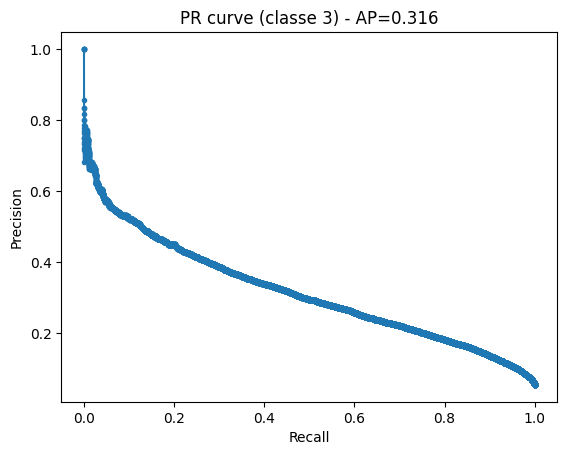

In [163]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

proba = hgb.predict_proba(Xte)[:, list(hgb.classes_).index(3)]  # probas pour la classe 3

precision, recall, thresholds = precision_recall_curve(y_acc_test_bin == 3, proba)
ap = average_precision_score(y_acc_test_bin == 3, proba)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR curve (classe 3) - AP={ap:.3f}')
plt.show()



In [164]:
from sklearn.metrics import classification_report, f1_score

def eval_thresholds(proba, y_true, thresholds):
    results = []
    for thr in thresholds:
        y_pred_thr = np.where(proba >= thr, 3, 12)
        f1 = f1_score(y_true, y_pred_thr, pos_label=3)
        report = classification_report(y_true, y_pred_thr, output_dict=True)
        results.append({
            "threshold": round(thr,3),
            "precision_3": round(report["3"]["precision"],3),
            "recall_3": round(report["3"]["recall"],3),
            "f1_3": round(report["3"]["f1-score"],3),
            "macro_f1": round((report["3"]["f1-score"]+report["12"]["f1-score"])/2,3)
        })
    return results

# Probabilités pour la classe 3
proba_3 = hgb.predict_proba(Xte)[:, list(hgb.classes_).index(3)]

# Chercher seuil qui maximise F1 classe 3
best_f1, best_thr = 0, 0.5
for t in np.linspace(0.05,0.95,50):
    y_tmp = np.where(proba_3 >= t, 3, 12)
    f1 = f1_score(y_acc_test_bin, y_tmp, pos_label=3)
    if f1 > best_f1:
        best_f1, best_thr = f1, t

print("Seuil optimal F1:", round(best_thr,3), "=> F1 classe 3 =", round(best_f1,3))

# Comparer quelques seuils
thresholds = [0.2, 0.5, 0.7, best_thr]
results = eval_thresholds(proba_3, y_acc_test_bin, thresholds)

import pandas as pd
pd.DataFrame(results)


Seuil optimal F1: 0.803 => F1 classe 3 = 0.373


,threshold,precision_3,recall_3,f1_3,macro_f1
0,0.200,0.104,0.956,0.188,0.436
1,0.500,0.176,0.814,0.290,0.580
2,0.700,0.249,0.618,0.355,0.644
3,0.803,0.322,0.442,0.373,0.665


Seuil bas (0.2)
> modèle prédit beaucoup trop d’accidents graves: recall max (95%) mais précision quasi nulle

Seuil standard (0.5)
> recall reste haut (81%): précision encore faible (18%), F1 ~0.29.

Seuil intermédiaire (0.7)
> équilibre mieux: précision monte à 25%, recall descend à 62%, F1 = 0.36.

Seuil optimal trouvé (0.803)
> compromis le plus équilibré : précision 32%, recall 44%, F1 = 0.37, macro-F1 max.

créer des Interactions : ex:nuit × météo défavorable, moto × choc frontal

Créer des indicateurs “graves”:
créer des flags binaires très informatifs :

Heure : nuit (22h–6h), heures de pointe (7–9h / 17–20h).

Lumière (lum) : sombre, éclairage absent/défectueux.

Météo (atm) : pluie, neige, brouillard.

Type de collision (col) : choc frontal, piéton, choc multiple.

Infrastructure (infra) : autoroute vs route secondaire.

Choc véhicule (choc) : choc avant / choc multiple.

ex:
df['is_night'] = df['hrmn'].between('22:00','06:00').astype(int)
df['is_bad_weather'] = df['atm'].isin([2,3,4,5,6,7]).astype(int)
df['is_dark'] = (df['lum'] > 2).astype(int)  # ex: codes >2 = pas bien éclairé
df['is_frontal'] = df['col'].isin([1,2]).astype(int)


In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    hgb, Xte, y_acc_test_bin,
    n_repeats=10, random_state=42, n_jobs=4
)

import pandas as pd

perm_imp = pd.DataFrame({
    "feature": Xtr.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

print(perm_imp.head(15))
